# Data SAO 184043

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time

import scipy.special as sc
from scipy.interpolate import interp1d
from astropy import units as u
from skyfield.api import load
import pymc as pm
import arviz as az

import aesara
import aesara.tensor as at
from aesara.compile.ops import as_op

az.style.use("arviz-darkgrid")
# plt.style.use(['science', 'notebook'])
# plt.style.use(['science', 'notebook', 'grid'])
pd.set_option('display.float_format',  '{:}'.format)

In [2]:
df = pd.read_csv("sao-184043.csv", sep=',')
df.head()

FrameNum            timeInfo  signal-stack  appsum-stack  avgbkg-stack  \
0    6400.0  [12:52:05.8441552]       43742.0     2562192.0      31091.98   
1    6401.0  [12:52:05.8542547]       53859.0     2565840.0      31012.12   
2    6402.0  [12:52:05.8643543]       69091.0     2587088.0      31086.39   
3    6403.0  [12:52:05.8744538]       82940.0     2594160.0      31002.71   
4    6404.0  [12:52:05.8845533]       24076.0     2539872.0      31059.21   

   stdbkg-stack  nmaskpx-stack  maxpx-stack  xcentroid-stack  ycentroid-stack  
0       1580.61            -81        37056            316.0            200.0  
1       1631.07            -81        38448            316.0            200.0  
2       1610.62            -81        36032            316.0            200.0  
3       1669.31            -81        40016            316.0            200.0  
4       1590.84            -81        35744            316.0            200.0

In [3]:
# hilangkan karakter [ dan ] dari data
df['timeInfo'] = df['timeInfo'].map((lambda x: x.lstrip('[').rstrip(']')))

# ubah ke format waktu dan ambil tanggal dan jamnya
df['timeInfo'] = pd.to_datetime(df['timeInfo'])

df.head()

FrameNum                   timeInfo  signal-stack  appsum-stack  \
0    6400.0 2022-07-27 12:52:05.844155       43742.0     2562192.0   
1    6401.0 2022-07-27 12:52:05.854254       53859.0     2565840.0   
2    6402.0 2022-07-27 12:52:05.864354       69091.0     2587088.0   
3    6403.0 2022-07-27 12:52:05.874453       82940.0     2594160.0   
4    6404.0 2022-07-27 12:52:05.884553       24076.0     2539872.0   

   avgbkg-stack  stdbkg-stack  nmaskpx-stack  maxpx-stack  xcentroid-stack  \
0      31091.98       1580.61            -81        37056            316.0   
1      31012.12       1631.07            -81        38448            316.0   
2      31086.39       1610.62            -81        36032            316.0   
3      31002.71       1669.31            -81        40016            316.0   
4      31059.21       1590.84            -81        35744            316.0   

   ycentroid-stack  
0            200.0  
1            200.0  
2            200.0  
3            200.0  
4            200.0

In [4]:
data = df[['FrameNum','timeInfo','signal-stack']]
data.columns = ['Frame','Date', 'Value']
data.head()

Frame                       Date   Value
0 6400.0 2022-07-27 12:52:05.844155 43742.0
1 6401.0 2022-07-27 12:52:05.854254 53859.0
2 6402.0 2022-07-27 12:52:05.864354 69091.0
3 6403.0 2022-07-27 12:52:05.874453 82940.0
4 6404.0 2022-07-27 12:52:05.884553 24076.0

In [5]:
data_copy = data.copy() # buat copy dari dataframe asli

data_copy['JD'] = Time(data_copy['Date']).jd

data_copy['frac_JD'] = data_copy['JD'] - np.floor(data_copy['JD']).astype(int)
data_copy

Frame                       Date    Value                 JD  \
0    6400.0 2022-07-27 12:52:05.844155  43742.0  2459788.036178752   
1    6401.0 2022-07-27 12:52:05.854254  53859.0 2459788.0361788687   
2    6402.0 2022-07-27 12:52:05.864354  69091.0 2459788.0361789856   
3    6403.0 2022-07-27 12:52:05.874453  82940.0 2459788.0361791025   
4    6404.0 2022-07-27 12:52:05.884553  24076.0 2459788.0361792194   
...     ...                        ...      ...                ...   
996  7396.0 2022-07-27 12:52:15.903378   7902.0  2459788.036295178   
997  7397.0 2022-07-27 12:52:15.913477 -14946.0 2459788.0362952948   
998  7398.0 2022-07-27 12:52:15.923577  17477.0 2459788.0362954116   
999  7399.0 2022-07-27 12:52:15.933676  27083.0 2459788.0362955285   
1000 7400.0 2022-07-27 12:52:15.943776   -522.0 2459788.0362956454   

                  frac_JD  
0     0.03617875184863806  
1     0.03617886872962117  
2    0.036178985610604286  
3      0.0361791024915874  
4    0.036179219372570515  
...                   ...  
996    0.0362951778806746  
997  0.036295294761657715  
998   0.03629541164264083  
999   0.03629552852362394  
1000  0.03629564540460706  

[1001 rows x 5 columns]

Text(0.5, 0, 'Frames')

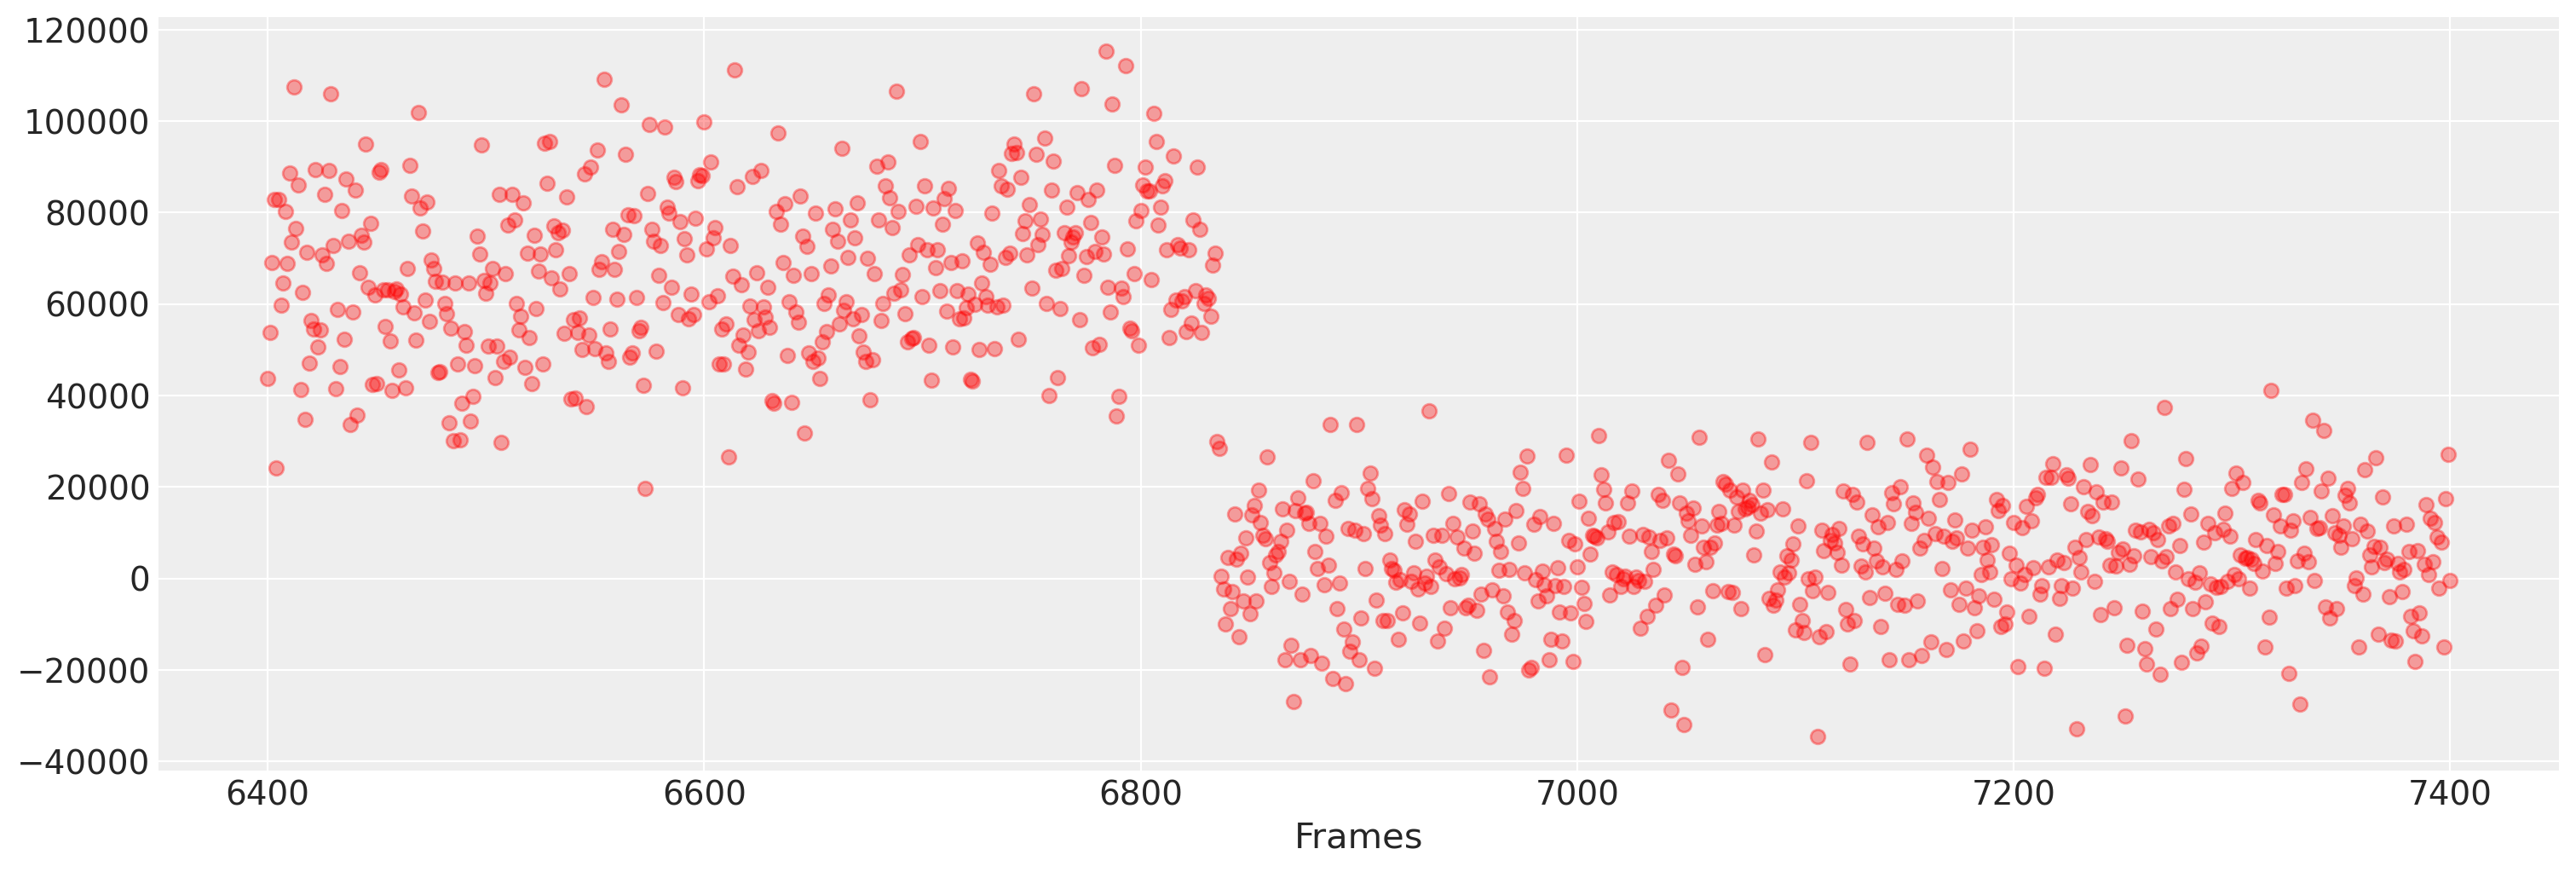

In [6]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(data_copy['Frame'], data_copy['Value'], 'ro', alpha=0.35)
# ax.set_xlim(3300, 3700)
ax.set_xlabel('Frames')

### Normalisasi

In [7]:
value_scaled = data_copy['Value']/(data_copy['Value'].std()*2)

Text(0.5, 0, 'Frames')

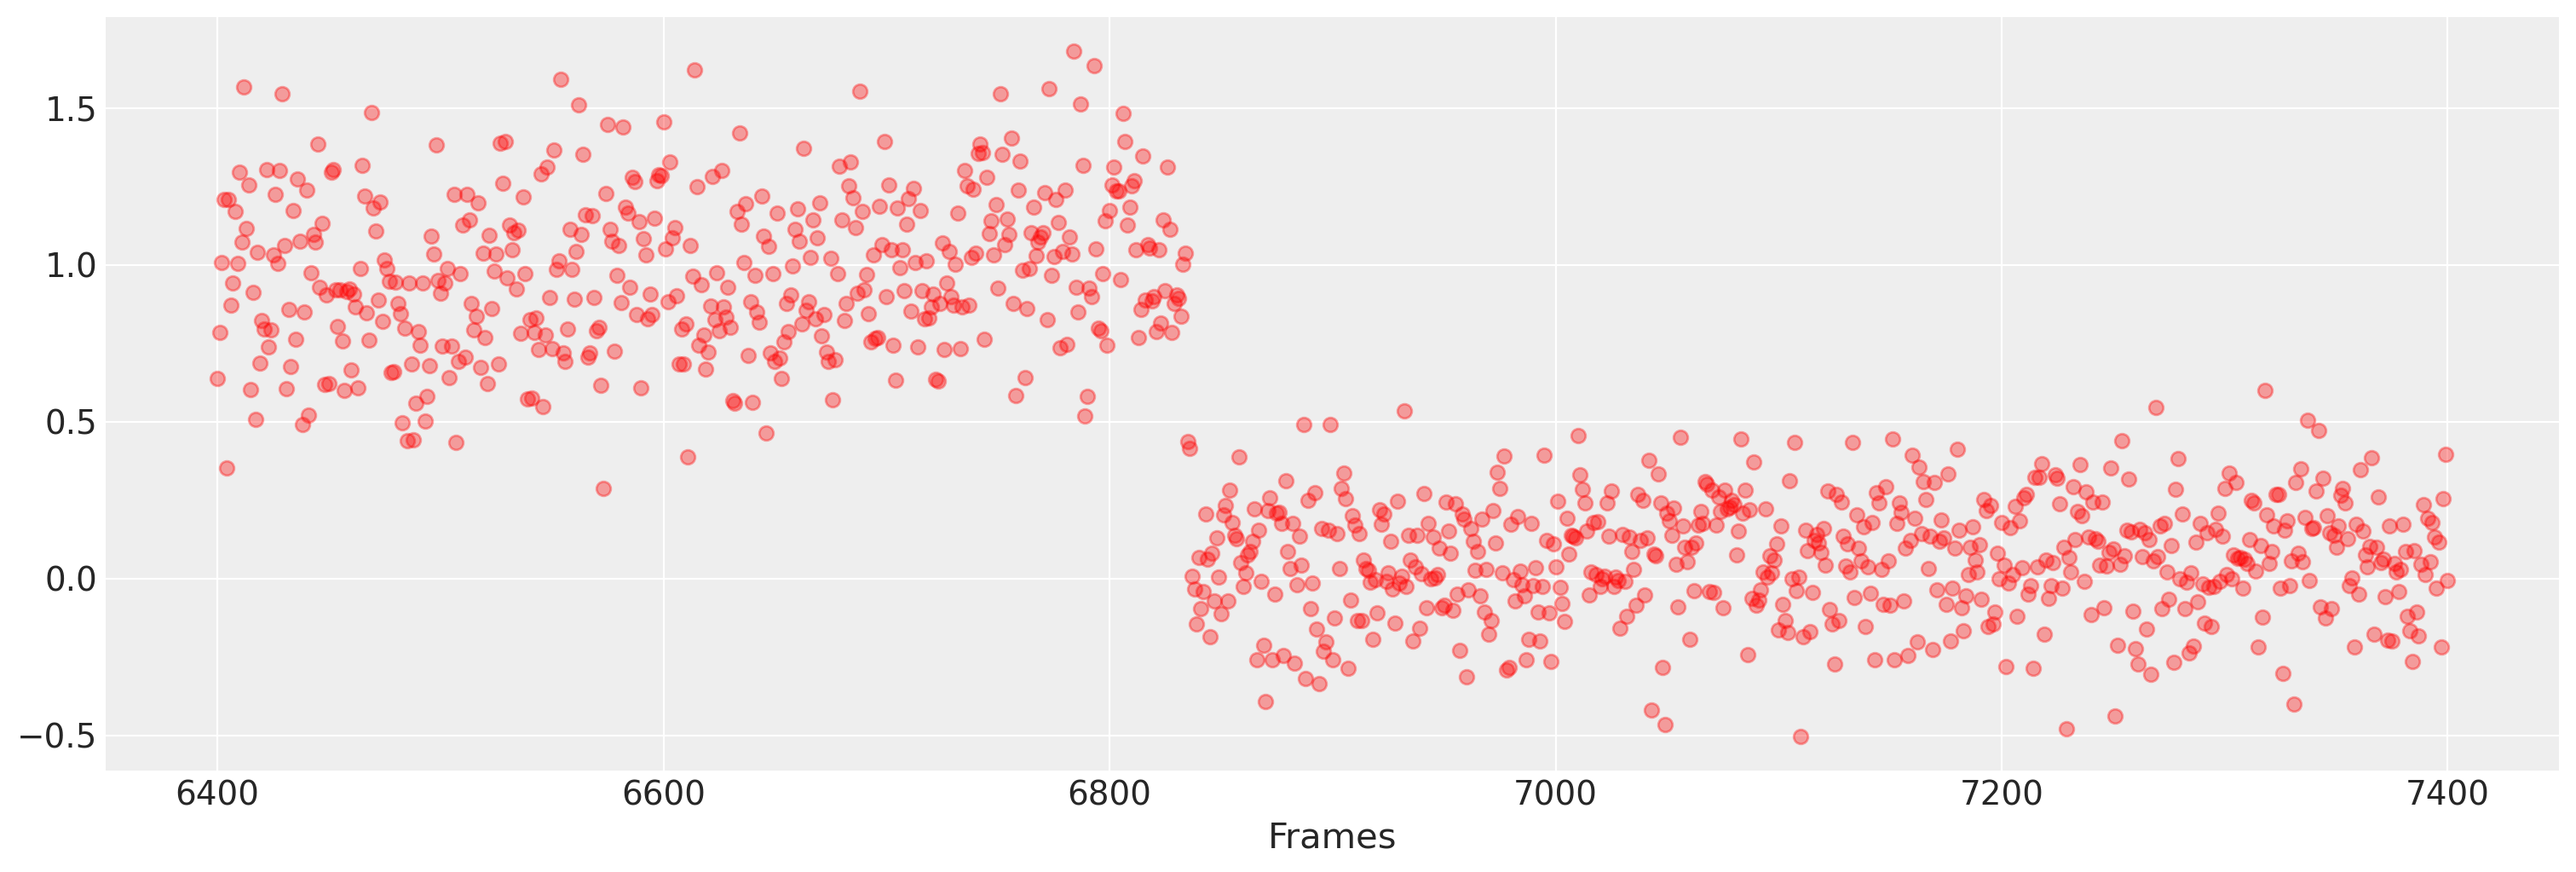

In [8]:
fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(data['frac_JD'], value_scaled, 'ro', alpha=0.35)
ax.plot(data_copy['Frame'], value_scaled, 'ro', alpha=0.35)
ax.set_xlabel('Frames')

### Kurva Benda Hitam untuk SAO 184043

#### Cari temperatur efektif

Temperatur efektif bintang bisa didekati dengan persamaan yang menghubungkan indeks warna bintang, $B - V$ dengan temperatur efektif bintang, $T_\mathrm{eff}$. Persamaan yang digunakan dalam pekerjaan ini diadopsi dari pekerjaan **Ballesteros 2012** (https://arxiv.org/pdf/1201.1809.pdf) sebagai berikut:

$$
T_\mathrm{eff} =  4600\left(\frac{1}{0.92 (B-V) + 1.7} + \frac{1}{0.92 (B-V) + 0.62} \right)
$$

In [9]:
# Satuan t_eff adalah Kelvin

def ballesteros(bv):
    return 4600. * ((1./(0.92*bv + 1.7)) + (1./(0.92*bv + 0.62)))

In [10]:
b = 7.27
v = 7.19

bv = b - v

teff = ballesteros(bv)
teff

9225.65953867021

In [11]:
def Planck(λ, T): 
    """
    λ: dalam cm
    T: dalam K
    """
    a = 3.7412e-5 / ((λ * 1e-7) **5) # 1e-7 adalah konversi dari nm ke cm
    b = np.exp(1.43879/(λ * 1e-7 * T)) - 1
    return a/b

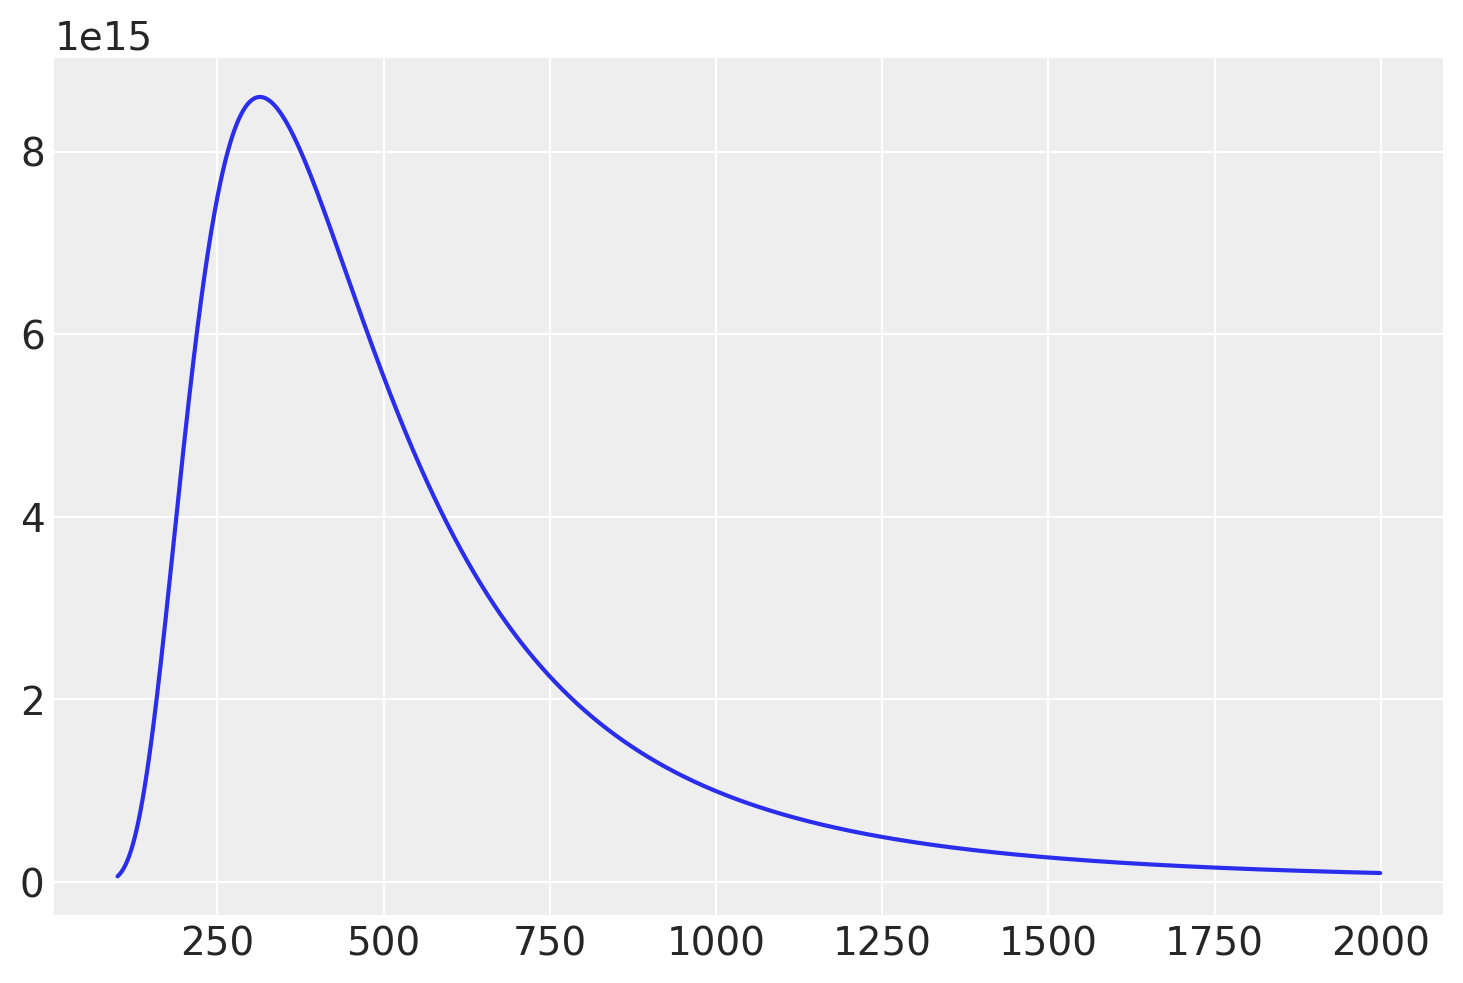

In [12]:
x_axis = np.arange(100, 2000)
y_axis = Planck(x_axis, teff)
plt.plot(x_axis, y_axis)

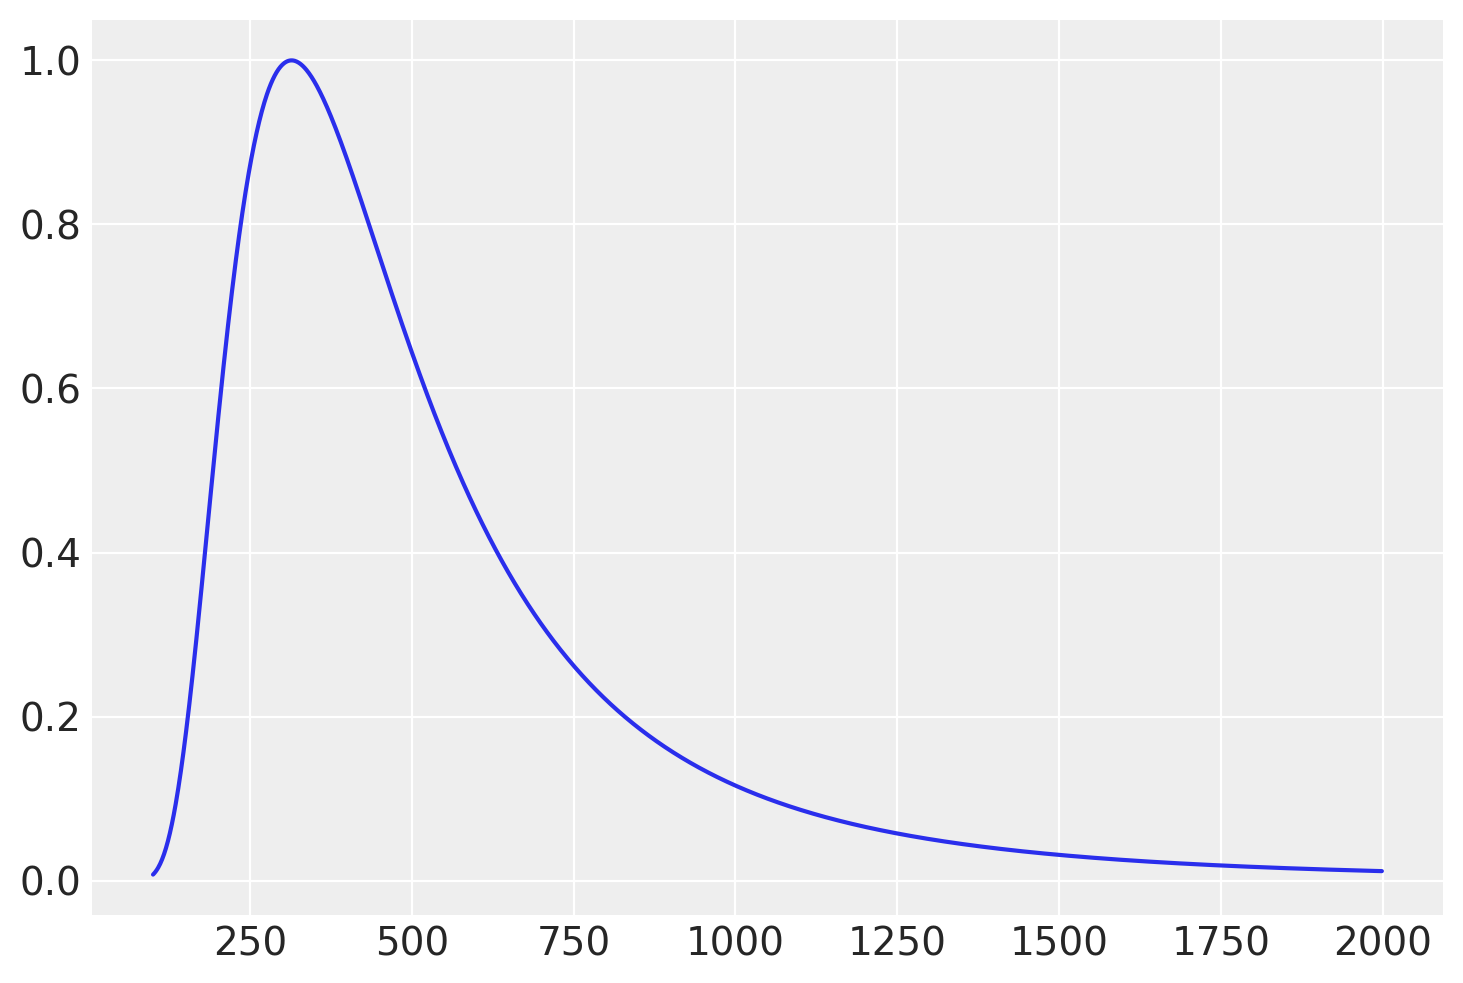

In [13]:
den = np.max(y_axis)

y_val = y_axis/den

plt.plot(x_axis, y_val)

### Kurva transmisi QHY 174M GPS *unfiltered*

In [14]:
df = pd.read_csv('qhy174_response.csv', delimiter=',', header='infer')
df.head()

wavelength  response
0       200.0       0.0
1       210.0       0.0
2       220.0       0.0
3       230.0       0.0
4       240.0       0.0

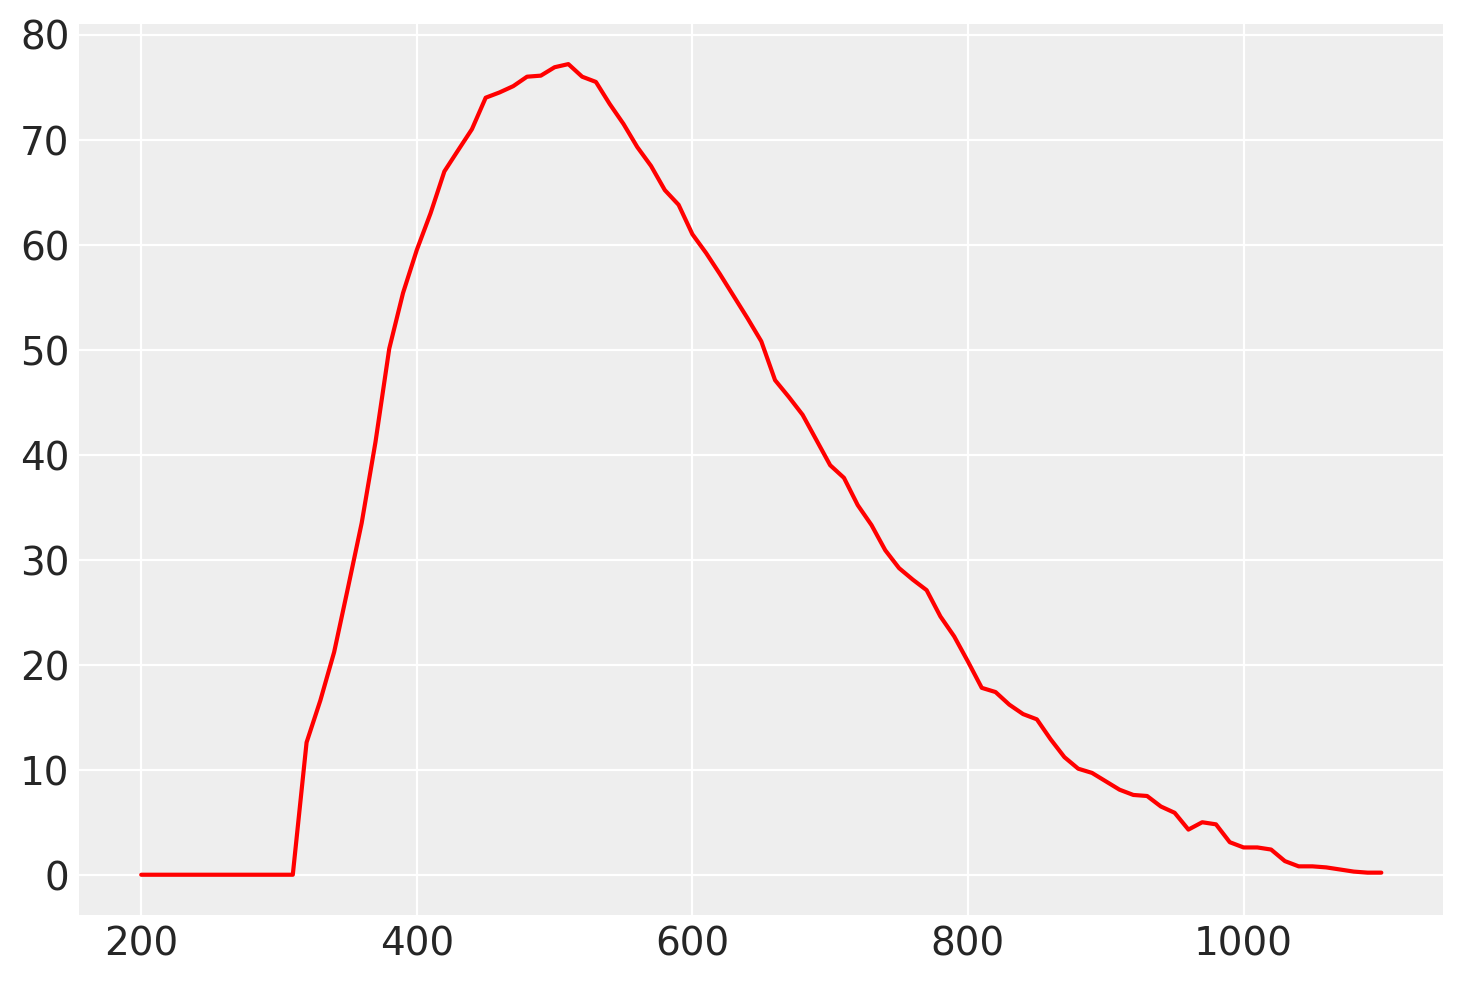

In [15]:
x = df['wavelength']
y = df['response']
plt.plot(x, y, 'r')

In [16]:
bandwidth = np.arange(330, 1100, 10) # rentang sesuai kurva transmisi

bandwidth

f_interp = interp1d(x, y, kind='cubic')

### Jarak Bulan saat pengamatan

Pengamatan dilakukan pada tanggal **10 Juli 2022 pukul 12:51:01.21 UT**

In [17]:
# load timescale dan tampilkan waktu saat ini
ts = load.timescale()

# custom waktu untuk yyyy, mm, dd, hh, mm, ss
t = ts.utc(2022, 7, 10, 12, 51, 1.21)

In [18]:
# Load the JPL ephemeris DE430 (covers 1549-2650) dan cari jarak Bumi-Bulan
planets = load('de430.bsp')
earth, moon = planets['earth'], planets['moon']

In [19]:
# posisi Bulan dari Bumi
astrometric = earth.at(t).observe(moon)
ra, dec, distance = astrometric.radec()

In [20]:
# tampilkan koordinat Bulan dan jarak Bulan dalam km
print(ra)
print(dec)
print(distance.km)

15h 59m 54.29s
-21deg 37' 29.6"
364488.7523980317


In [21]:
d_moon = distance.km
d_moon

364488.7523980317

### Inisiasi model

In [22]:
x_data = np.array(data_copy['Frame'])
y_data = np.array(data_copy['Value'])

In [23]:
def fresnel_polikromatik(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        # model untuk disappearance
        cc, ss = sc.fresnel(-w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp(bandwidth[i]) * (Planck(bandwidth[i], T)/den) * y
        # y_new = f_interp(bandwidth[i]) * y
        y0 += y_new
    return y0

In [24]:
# Variabel benar
# -------------
x0_true = 6840
A_true = 1.
σ_true = 300
T = teff

In [25]:
y_syn = fresnel_polikromatik(x_data, x0_true, d_moon, A_true)
y_syn = np.random.normal(y_syn, scale=σ_true)

y_syn_scaled = y_syn / (y_syn.std()*2)

Text(0, 0.5, 'Intensity')

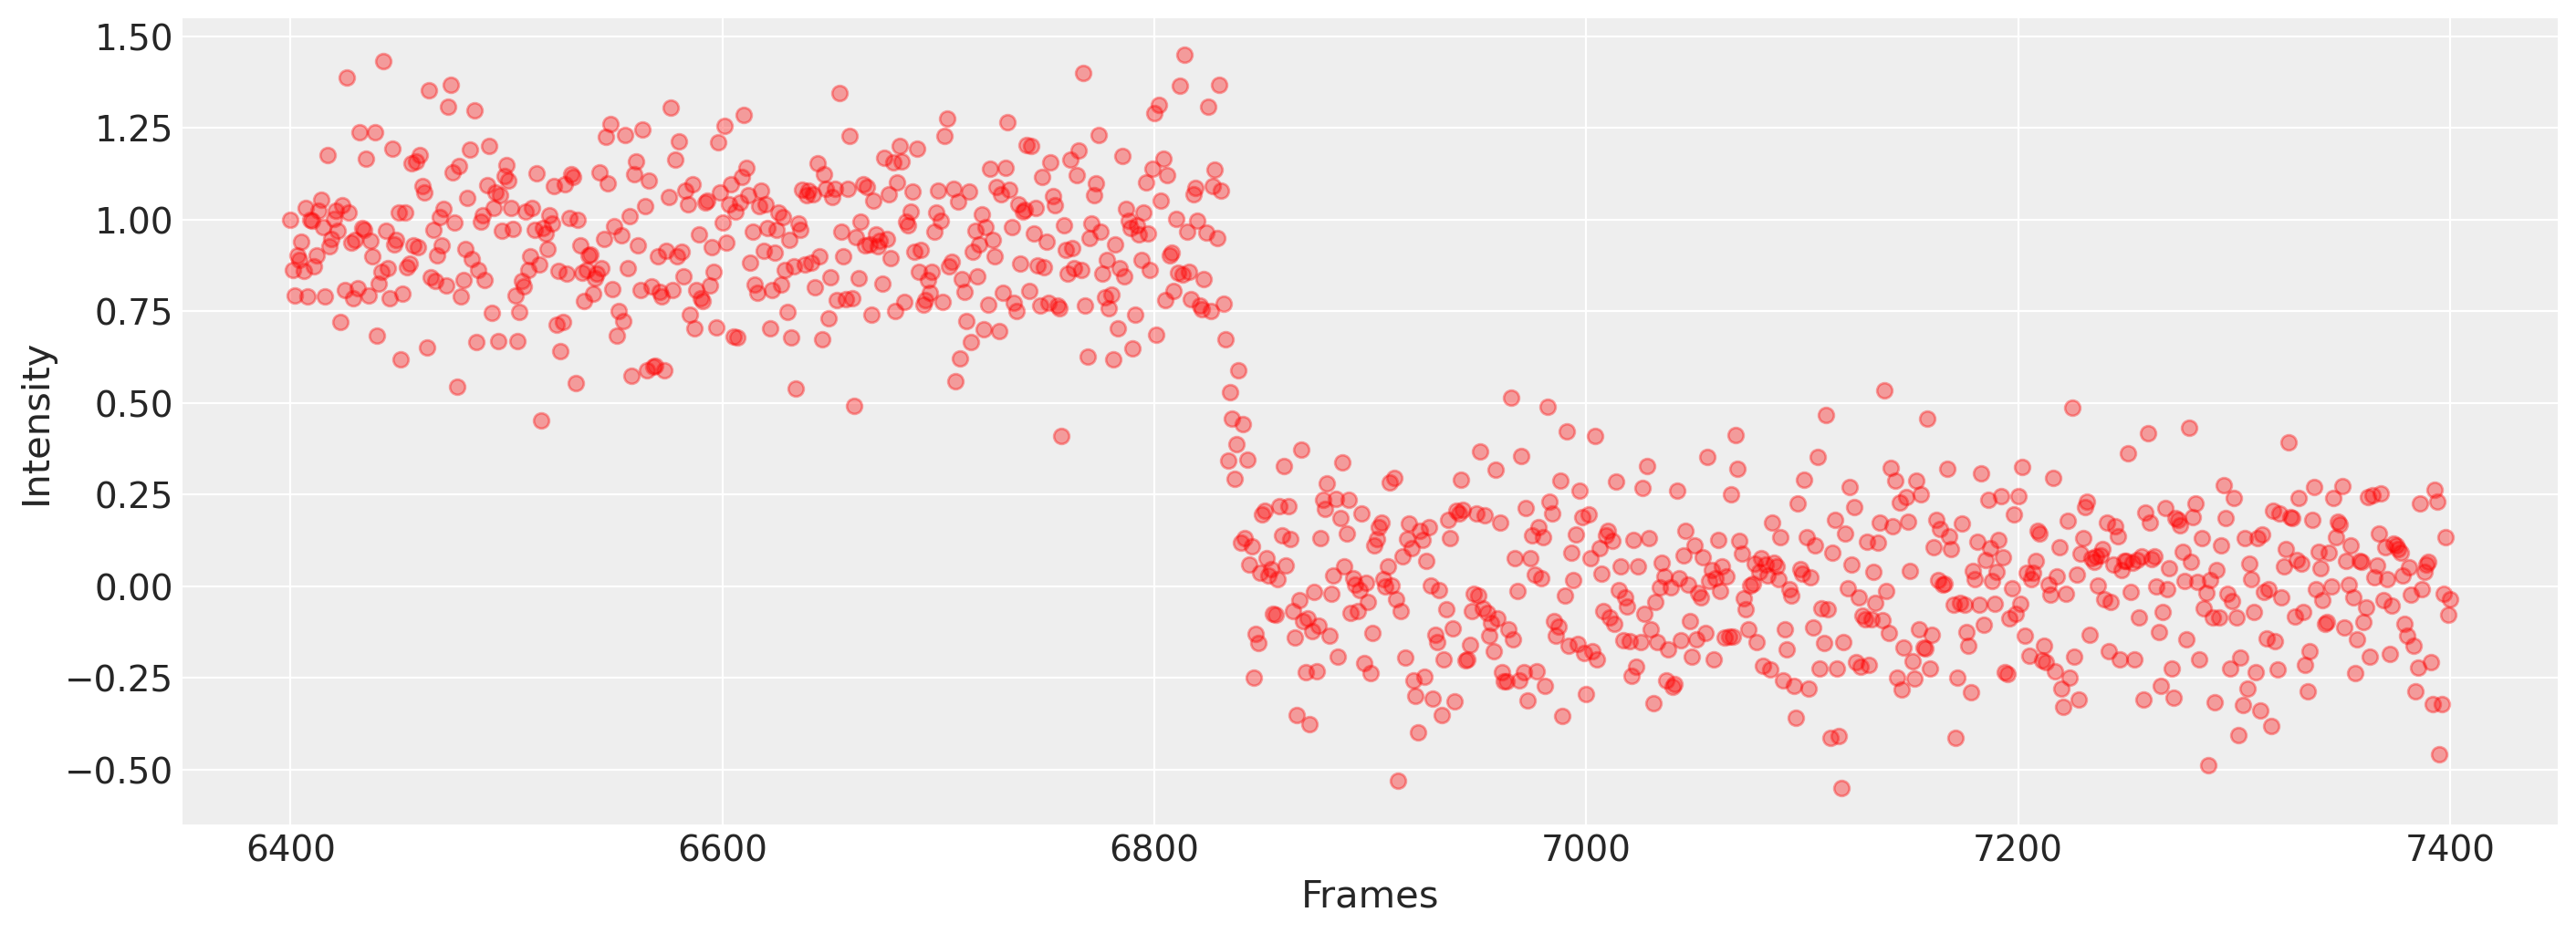

In [26]:
plt.figure(figsize = (14,5), facecolor='w')
plt.scatter(x_data, y_syn_scaled, marker='o', c='r', alpha=0.35)
plt.xlabel('Frames')
plt.ylabel('Intensity')

In [27]:
@as_op(itypes=[at.dvector, at.dscalar, at.dscalar, at.dscalar], otypes=[at.dvector])
def t_fresnel_polikromatik(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(-w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp(bandwidth[i]) * (Planck(bandwidth[i], T)/den) * y
        y0 += y_new
    return y0

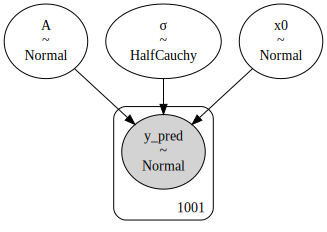

In [28]:
x_shared = aesara.shared(x_data)
d_shared = aesara.shared(d_moon)

with pm.Model() as model_polikromatik:
    A = pm.Normal('A', mu=1., sigma=1.)
    σ = pm.HalfCauchy('σ', beta=1.)
    x0 = pm.Normal('x0', mu=6840., sigma=1.)
    
    μ = t_fresnel_polikromatik(x_shared, x0, d_shared, A)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=value_scaled)
    
pm.model_to_graphviz(model_polikromatik)

In [29]:
with model_polikromatik:
    idata = pm.sample(cores=1)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Slice: [A]
>>Slice: [x0]
>NUTS: [σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1133 seconds.


In [30]:
az.summary(idata)

mean    sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
A     0.001   0.0    0.001    0.001        0.0      0.0    1793.0    1586.0   
x0 6838.596 0.566 6837.538 6839.685      0.013    0.009    1923.0    1417.0   
σ     0.222 0.005    0.213    0.232        0.0      0.0     860.0    1476.0   

    r_hat  
A     1.0  
x0    1.0  
σ     1.0

array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'x0'}>,
        <AxesSubplot:title={'center':'x0'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

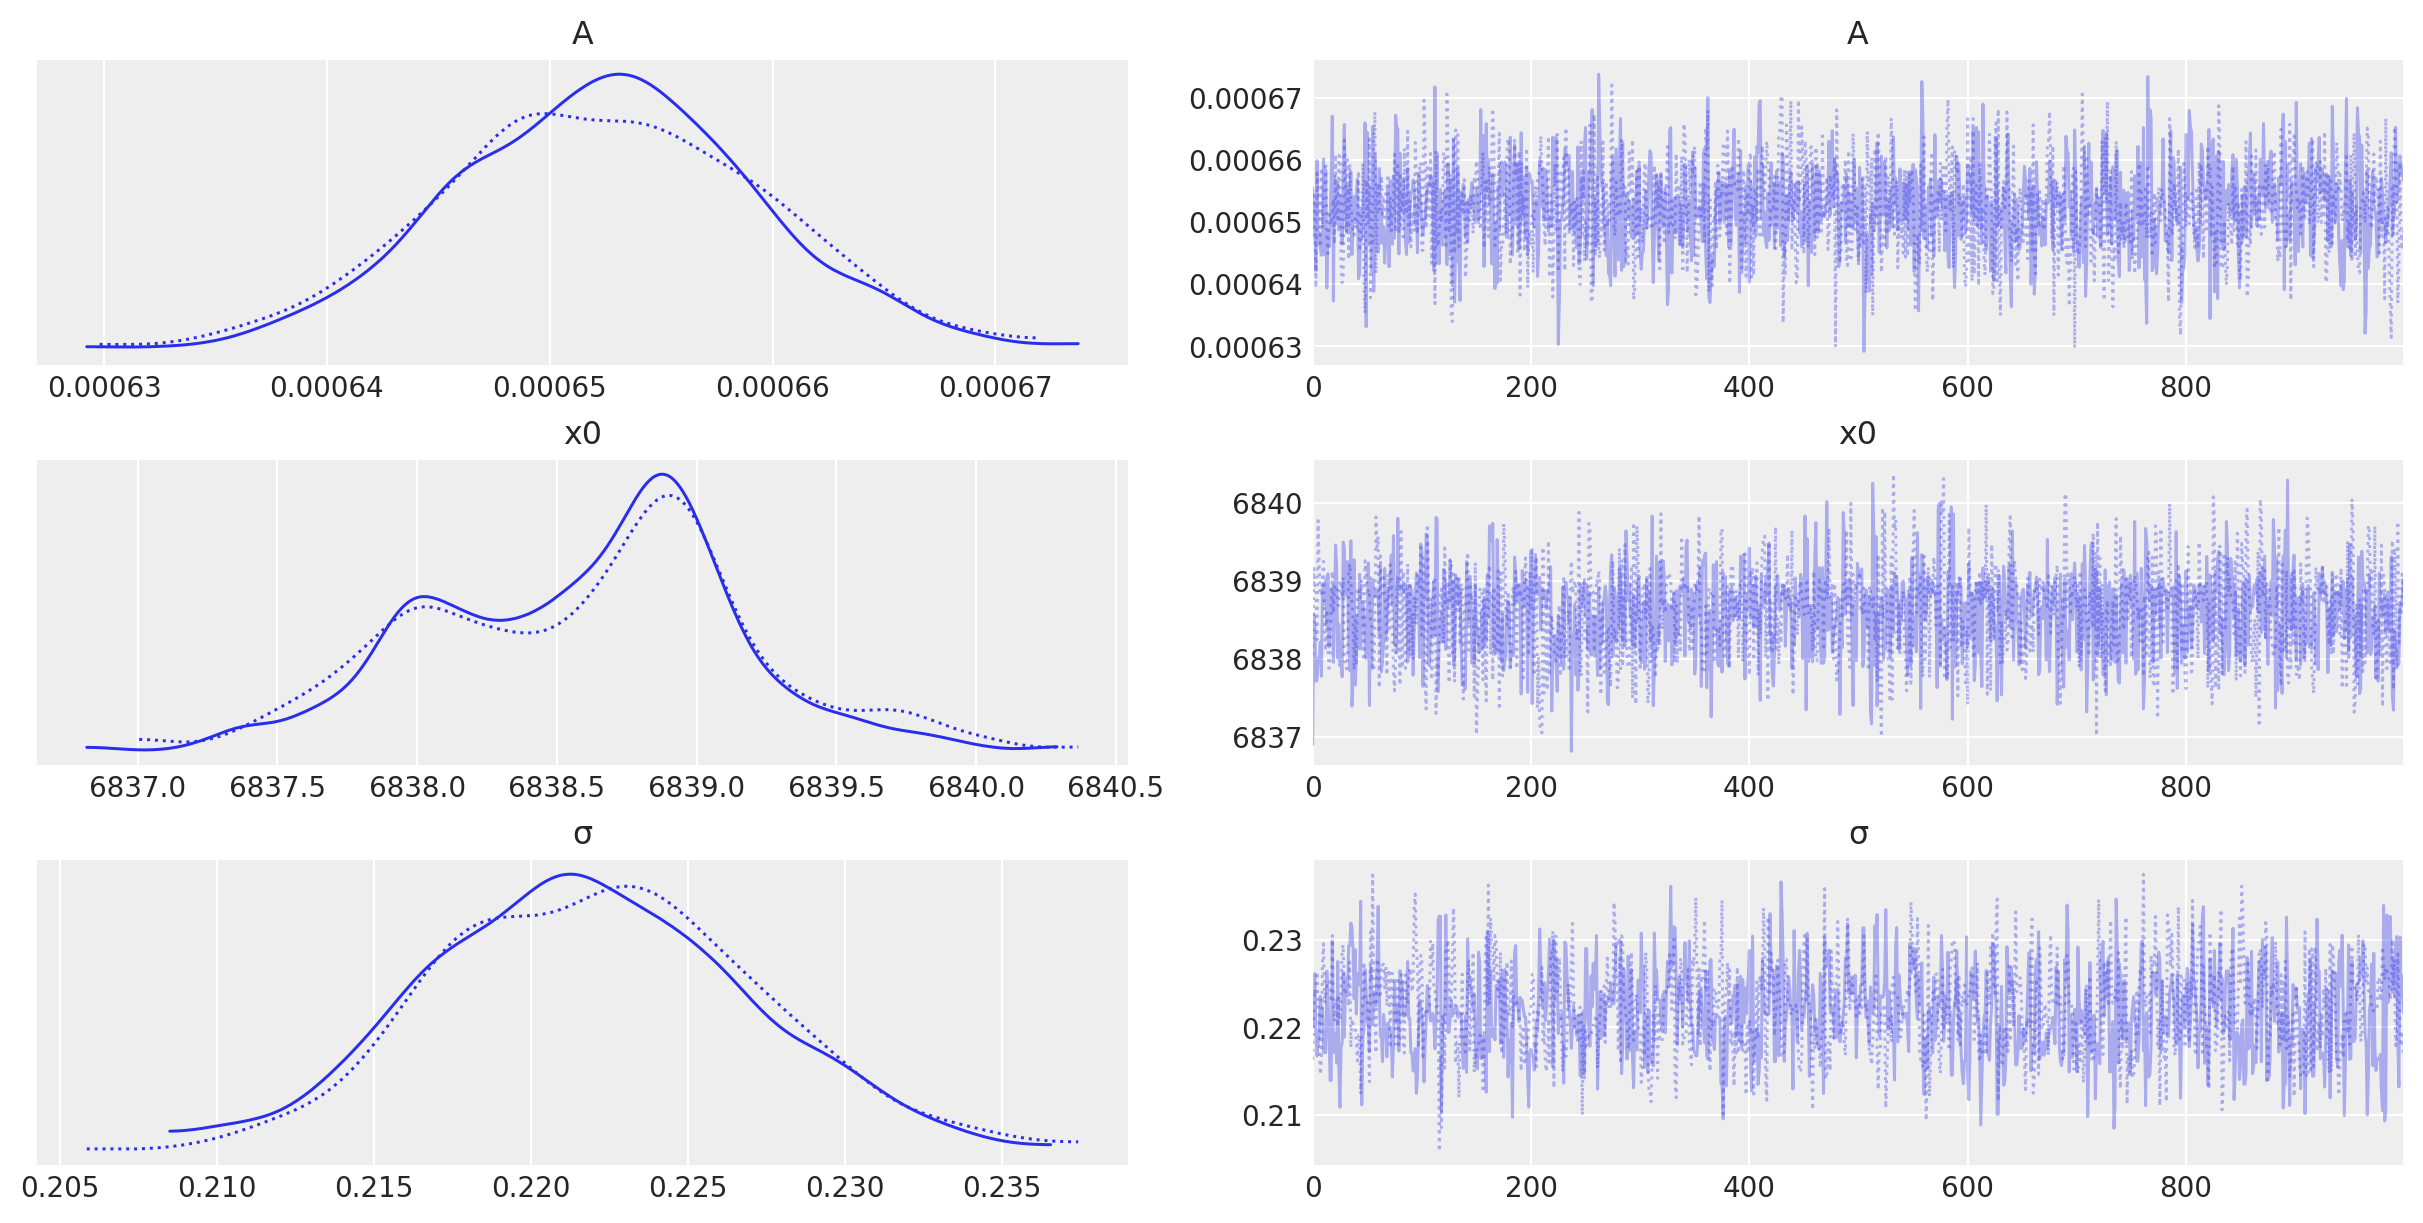

In [31]:
az.plot_trace(idata)

In [32]:
idata_pp = idata.posterior_predictive

idata_pp_st = idata_pp.stack(sample=("chain", "draw"))

crit_l = np.percentile(idata_pp_st['y_pred'], 2.5, axis=1)  # 2.5% persentil 
crit_u = np.percentile(idata_pp_st['y_pred'], 97.5, axis=1)  # 97.5% persentil
mean_spp = np.mean(idata_pp_st['y_pred'], axis=1) # Median

C:\Users\User\AppData\Local\Temp\ipykernel_3428\2079352553.py:9: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


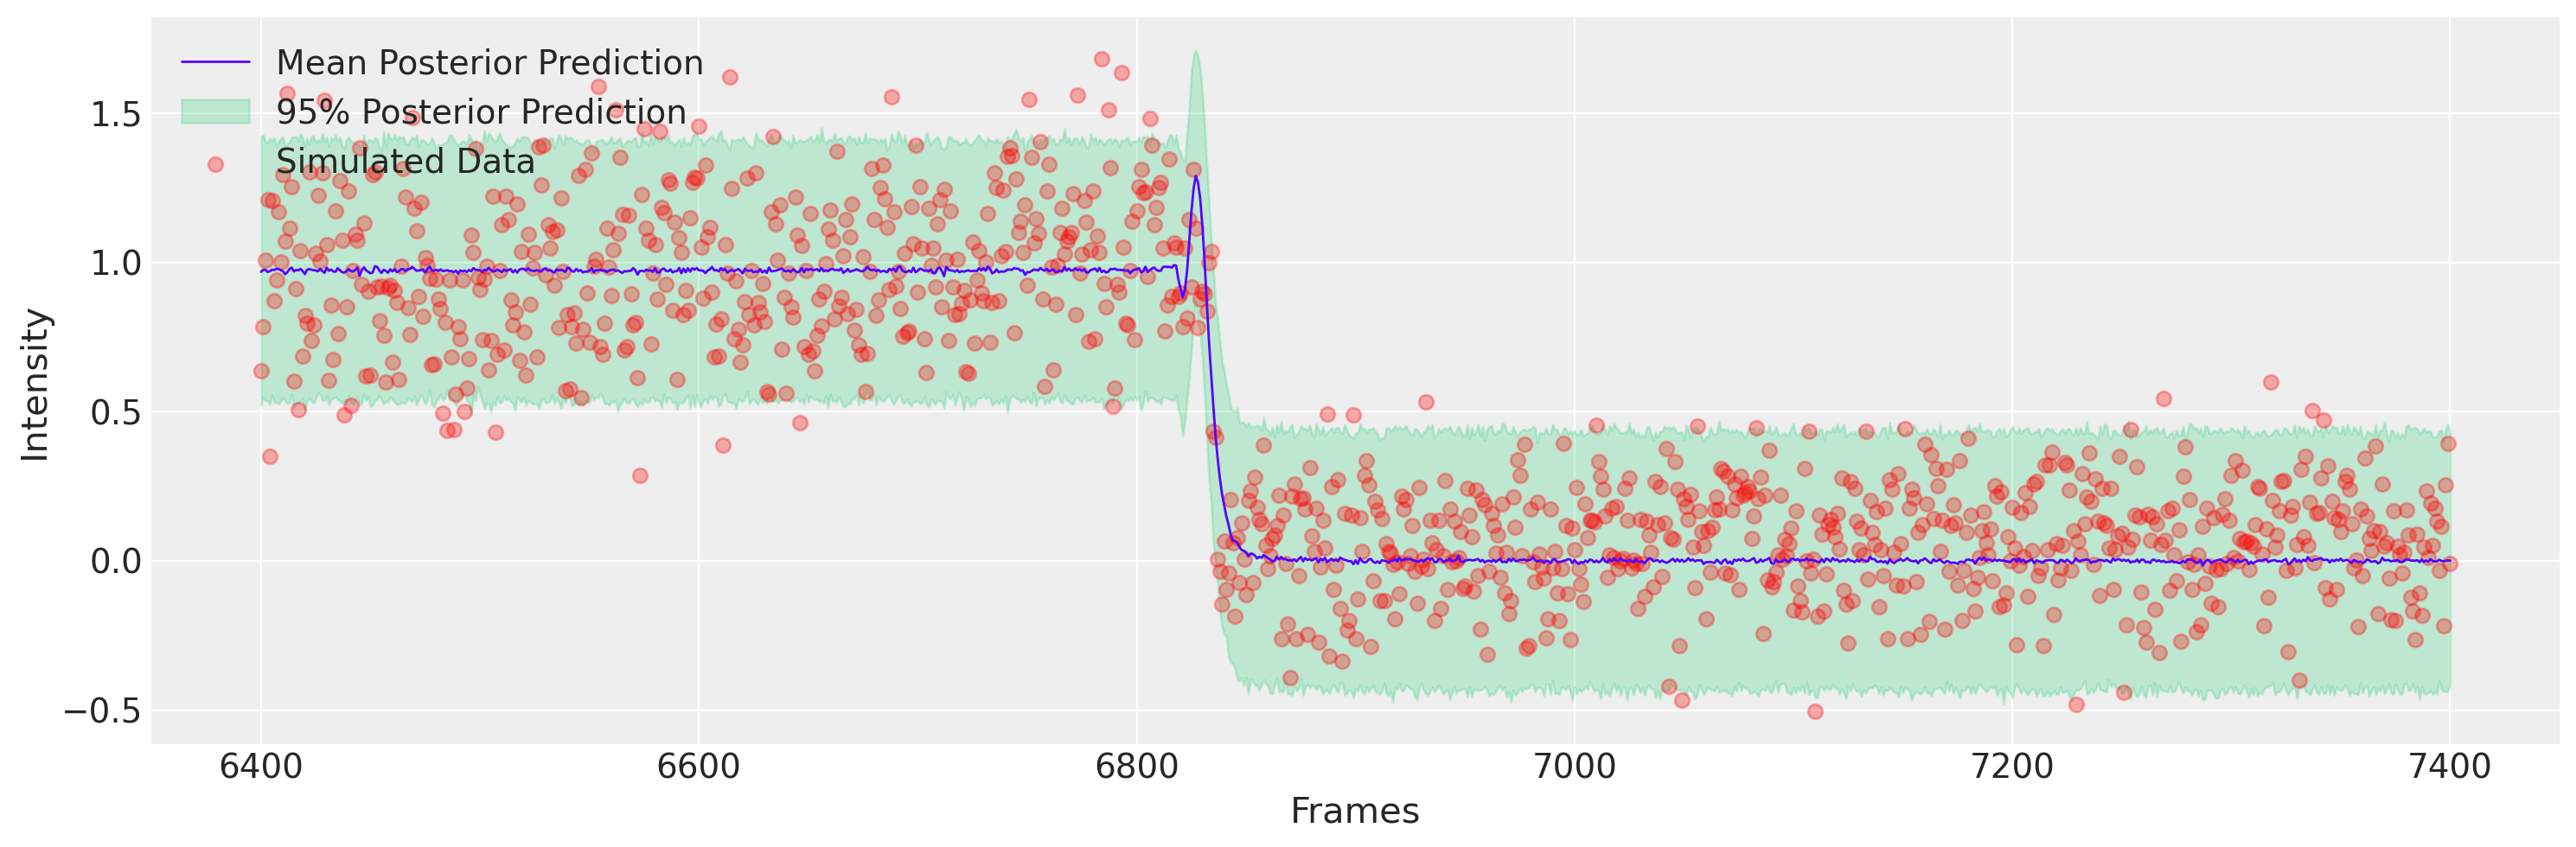

In [33]:
plt.figure(figsize=(15,5))
plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data, crit_l, crit_u, alpha=0.2, color="#00cc66")
plt.scatter(x_data, value_scaled, c='r', marker='o', alpha=0.3)
# plt.plot(x_data, y_data, 'r-', lw=1, alpha=0.5)
plt.xlabel('Frames')
# plt.xlim(3300, 3700)
plt.ylabel('Intensity')
plt.tight_layout()
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'], loc='upper left')
# plt.savefig('hasil-kurvatransmisi-planck.png', dpi=150)

###  *Data smoothing*

In [34]:
from scipy.signal import savgol_filter

In [35]:
y_filtered = savgol_filter(value_scaled, 10, 2)

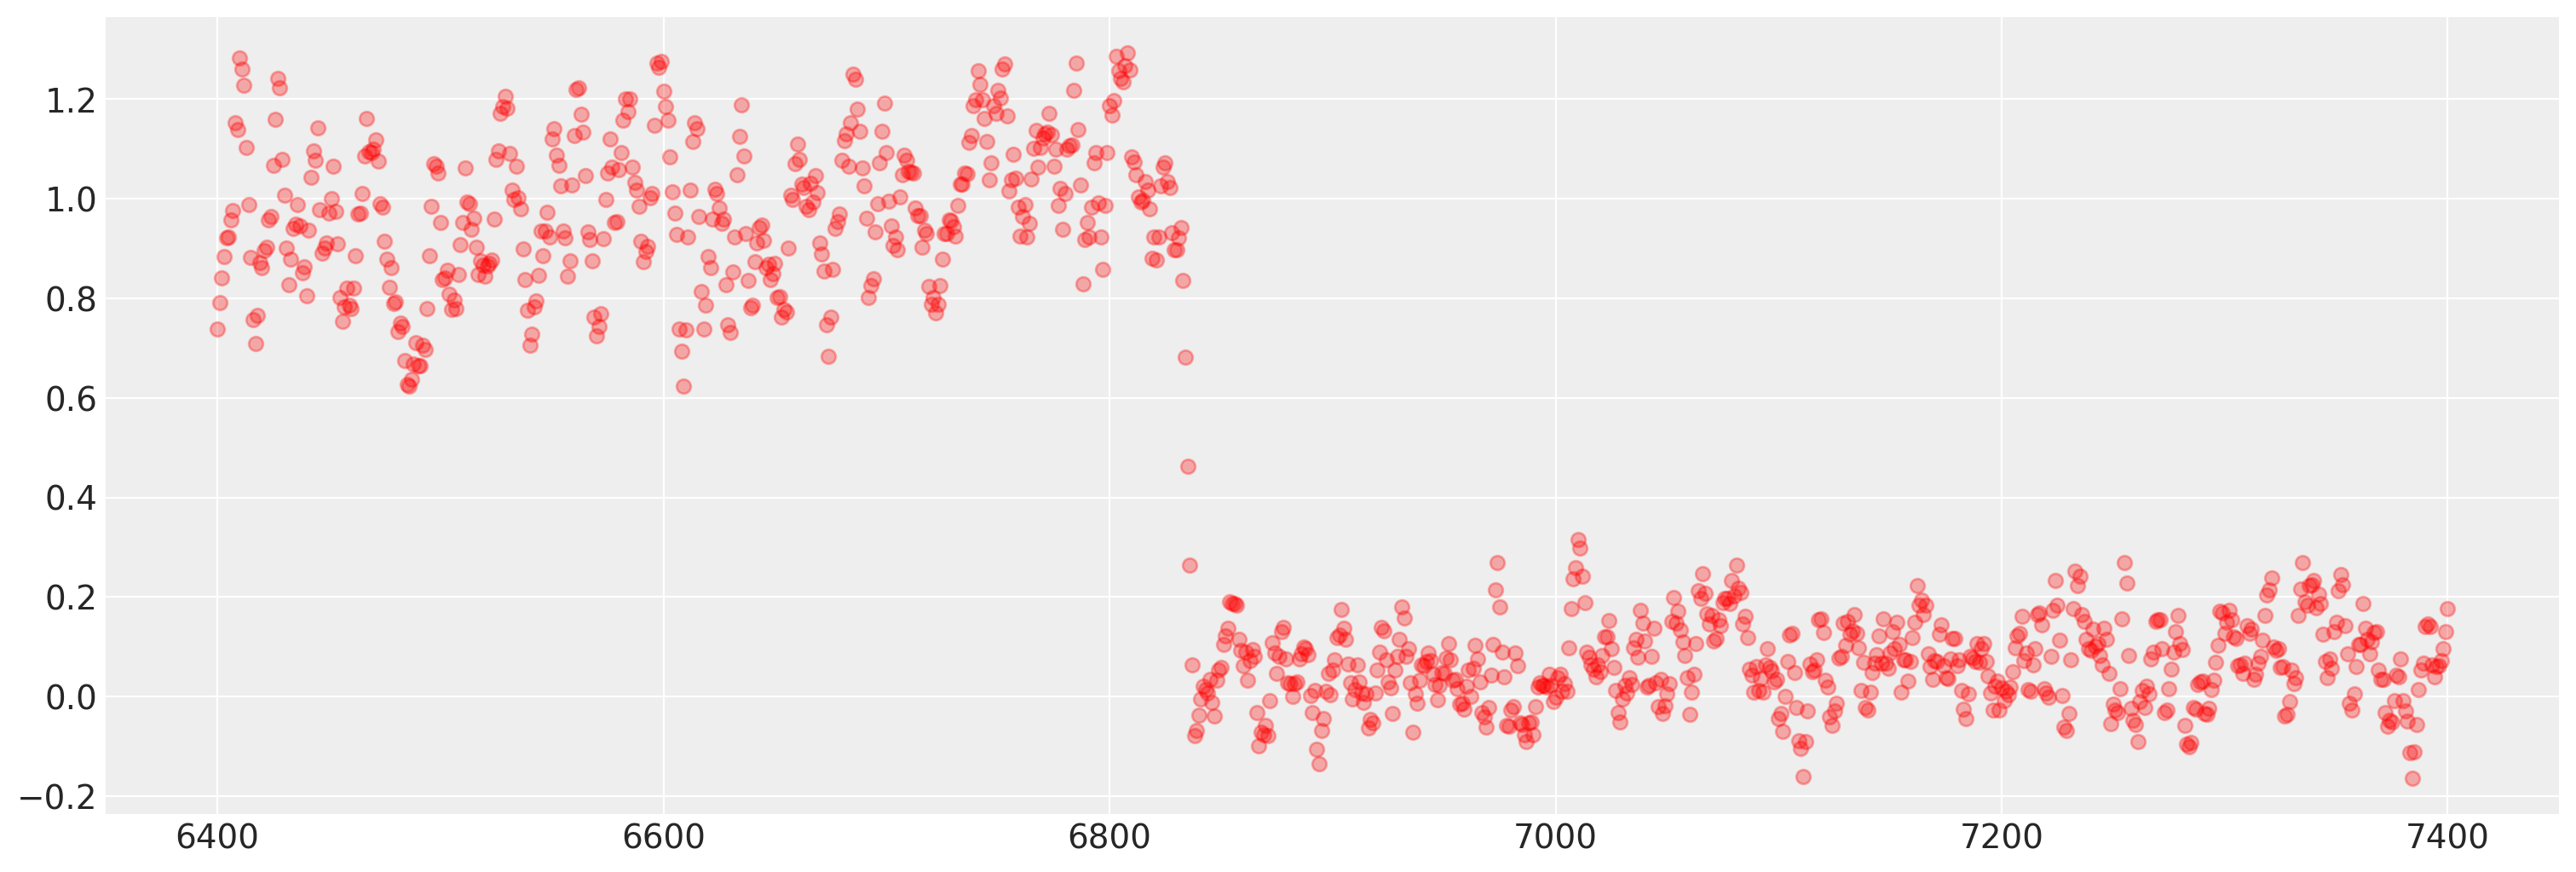

In [36]:
plt.figure(figsize=(15,5))
plt.scatter(x_data, y_filtered, c='r', marker='o', alpha=0.3)
# plt.xlim(3300, 3700)

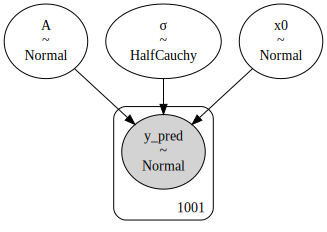

In [37]:
with pm.Model() as model_polikromatik_smt:
    A = pm.Normal('A', mu=1., sigma=1.)
    σ = pm.HalfCauchy('σ', beta=1.)
    x0 = pm.Normal('x0', mu=6840., sigma=1.)
    
    μ = t_fresnel_polikromatik(x_shared, x0, d_shared, A)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=y_filtered)
    
pm.model_to_graphviz(model_polikromatik_smt)

In [38]:
with model_polikromatik_smt:
    idata = pm.sample(cores=1)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Slice: [A]
>>Slice: [x0]
>NUTS: [σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1240 seconds.


array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'x0'}>,
        <AxesSubplot:title={'center':'x0'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

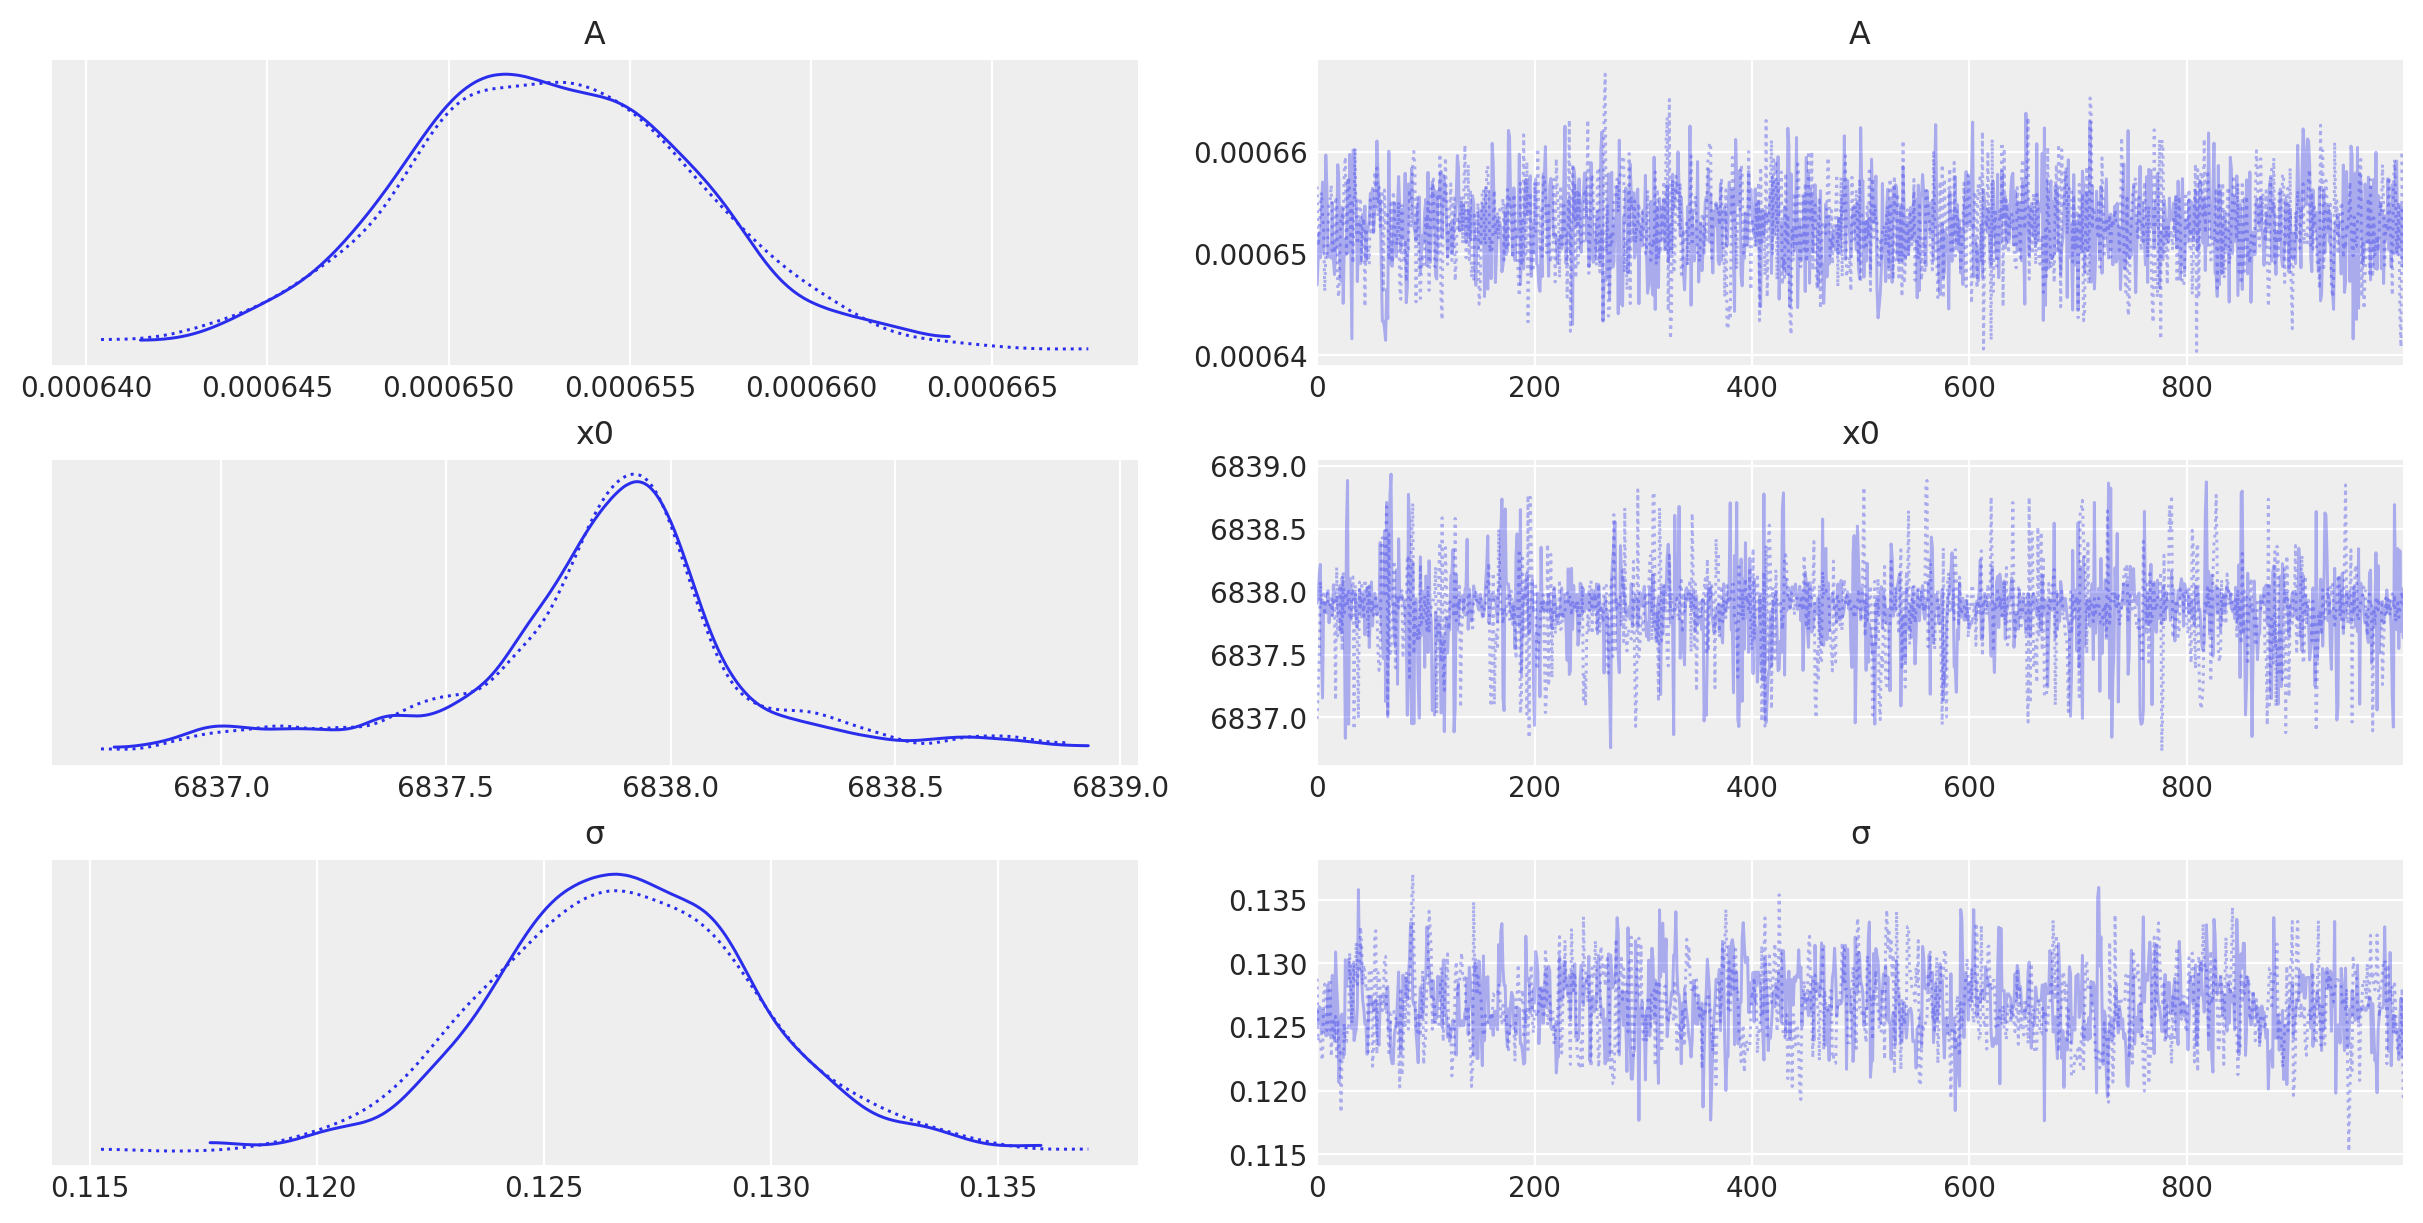

In [39]:
az.plot_trace(idata)

In [40]:
az.summary(idata)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
A     0.001   0.0   0.001    0.001        0.0      0.0    1957.0    1304.0   
x0 6837.847  0.33 6836.98 6838.405      0.008    0.005    1964.0    1226.0   
σ     0.127 0.003   0.121    0.132        0.0      0.0     816.0    1425.0   

    r_hat  
A     1.0  
x0    1.0  
σ     1.0

In [41]:
idata_pp = idata.posterior_predictive

idata_pp_st = idata_pp.stack(sample=("chain", "draw"))

crit_l_smt = np.percentile(idata_pp_st['y_pred'], 2.5, axis=1)  # 2.5% persentil 
crit_u_smt = np.percentile(idata_pp_st['y_pred'], 97.5, axis=1)  # 97.5% persentil
mean_spp = np.mean(idata_pp_st['y_pred'], axis=1) # Median

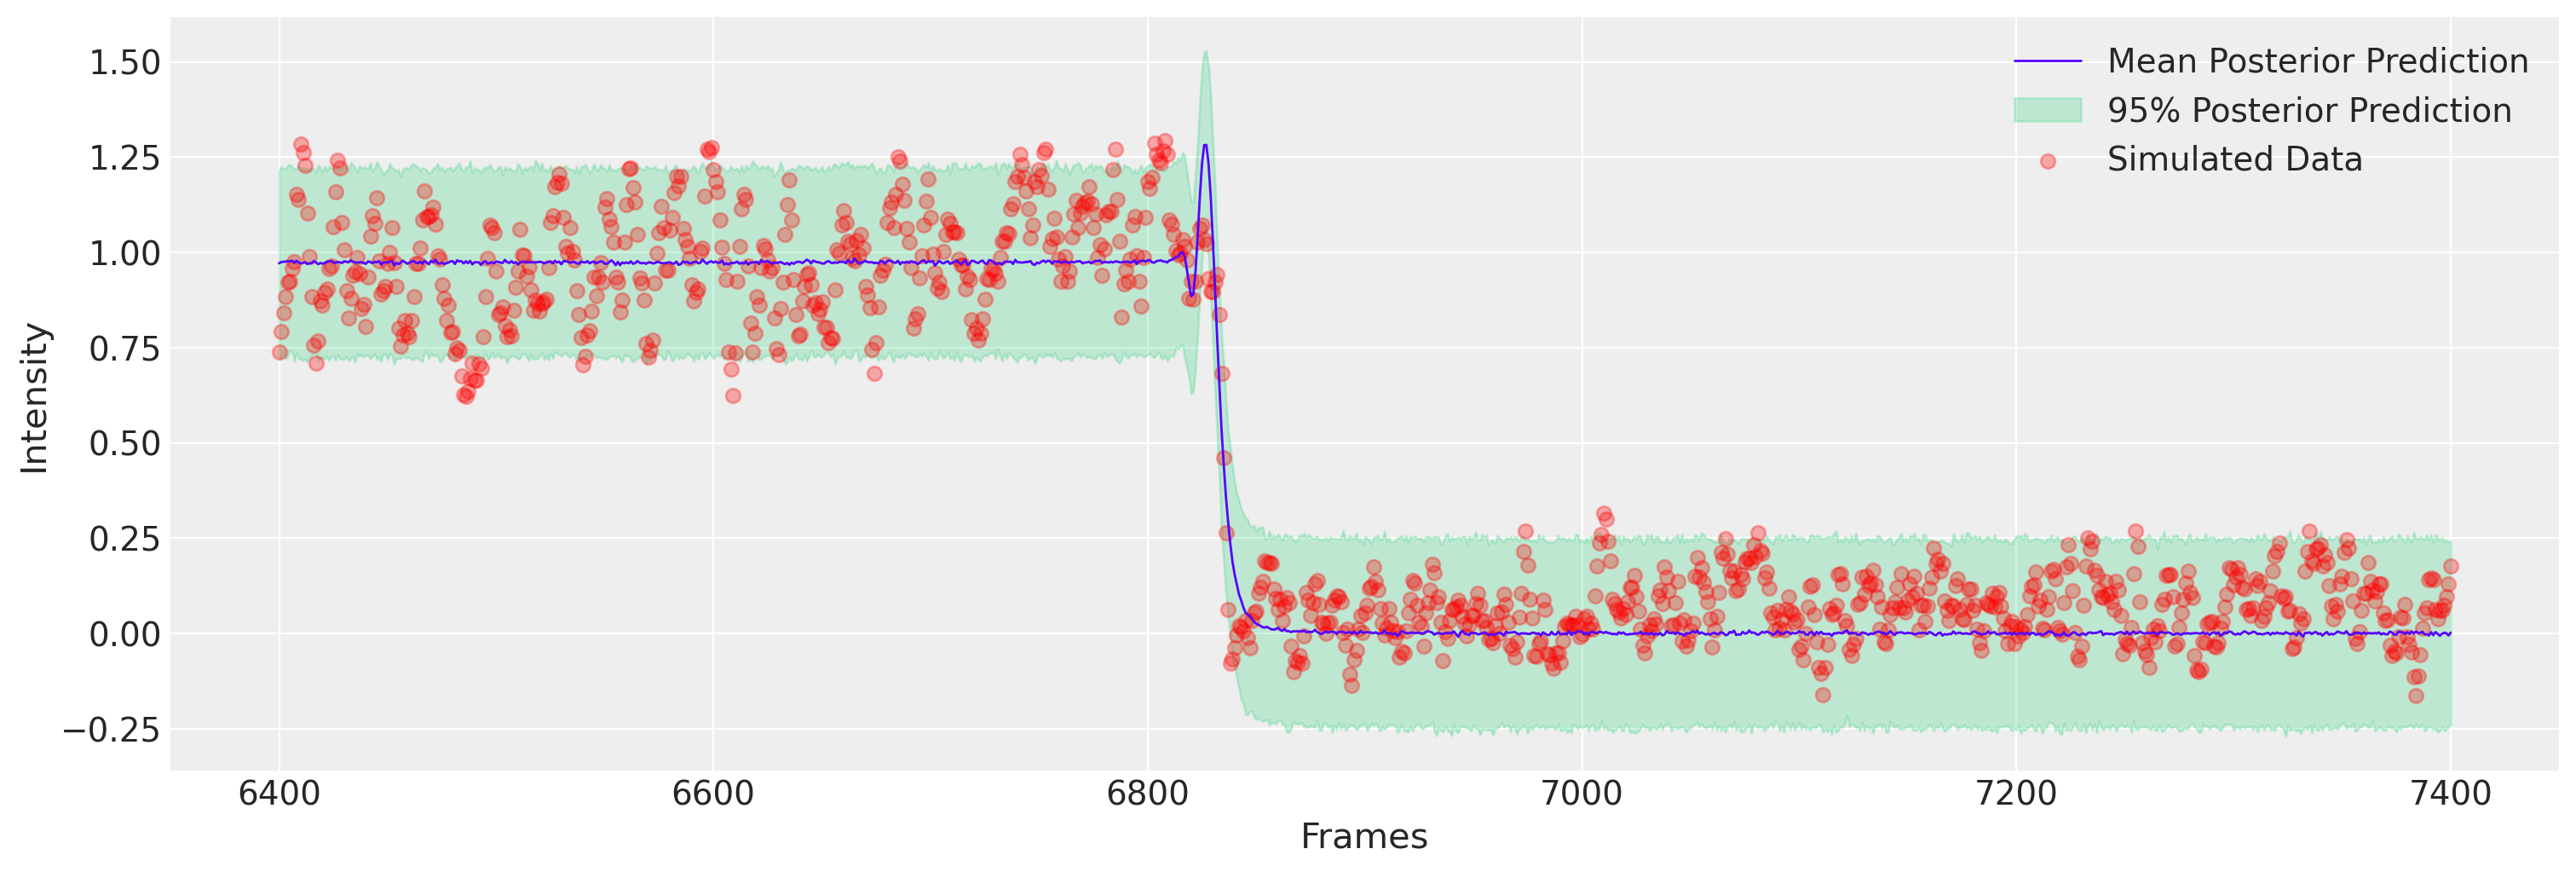

In [42]:
plt.figure(figsize=(15,5))
plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data, crit_l_smt, crit_u_smt, alpha=0.2, color="#00cc66")
plt.scatter(x_data, y_filtered, c='r', marker='o', alpha=0.3)
# plt.plot(x_data, y_data, 'r-', lw=1, alpha=0.5)
plt.xlabel('Frames')
# plt.xlim(4900, 5200)
plt.ylabel('Intensity')
# plt.tight_layout()
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'], loc='upper right')
# plt.savefig('hasil-kurvatransmisi-planck.png', dpi=150)

### Konversi *frame number* ke waktu

Text(0, 0.5, 'Julian Date')

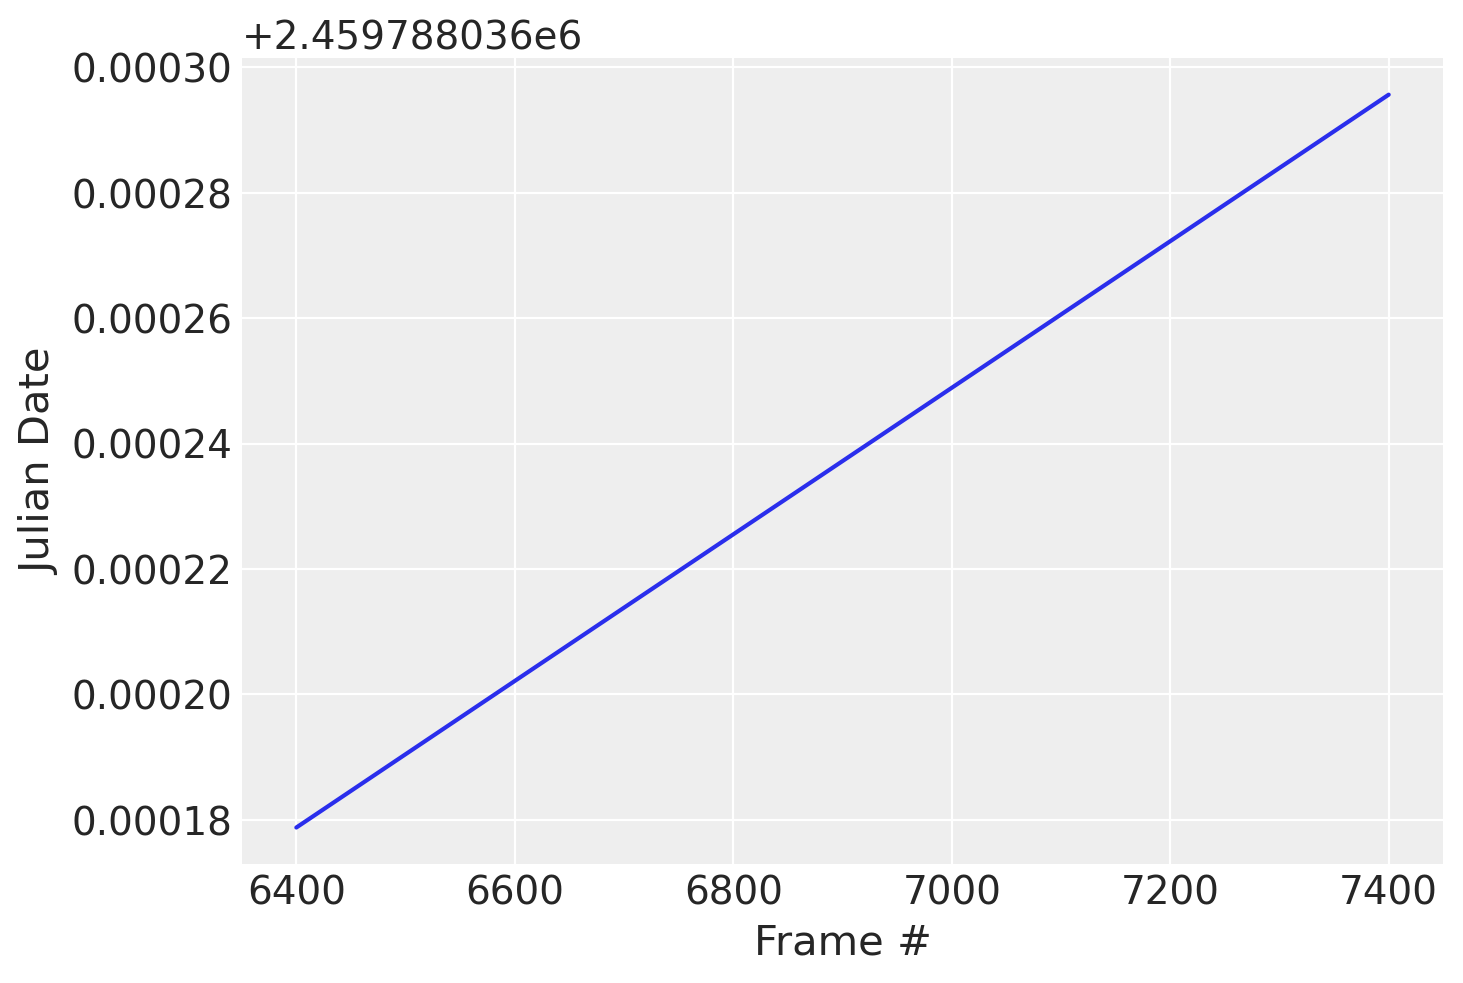

In [43]:
x = data_copy['Frame']
y = data_copy['JD']

plt.plot(x, y)
plt.xlabel('Frame #')
plt.ylabel('Julian Date')

In [44]:
f = interp1d(x, y, kind='cubic')

#### Ambil nilai dari `arviz inference data`

In [45]:
framenum = idata.posterior.mean().x0.values

# interpolasi

date = f(framenum)
type(date)

numpy.ndarray

### Ubah `ndarray` ke `str`

In [46]:
date_str = np.array_str(date)
date_str

'2459788.036229933'

In [47]:
# Ubah ke format waktu

j_date = Time(date_str, format='jd')
# j_date.value
iso_time = j_date.iso
iso_time

'2022-07-27 12:52:10.266'

### Ubah `str` ke format `timestamp`

In [48]:
t_iso_time = pd.to_datetime(iso_time)
t_iso_time

Timestamp('2022-07-27 12:52:10.266000')

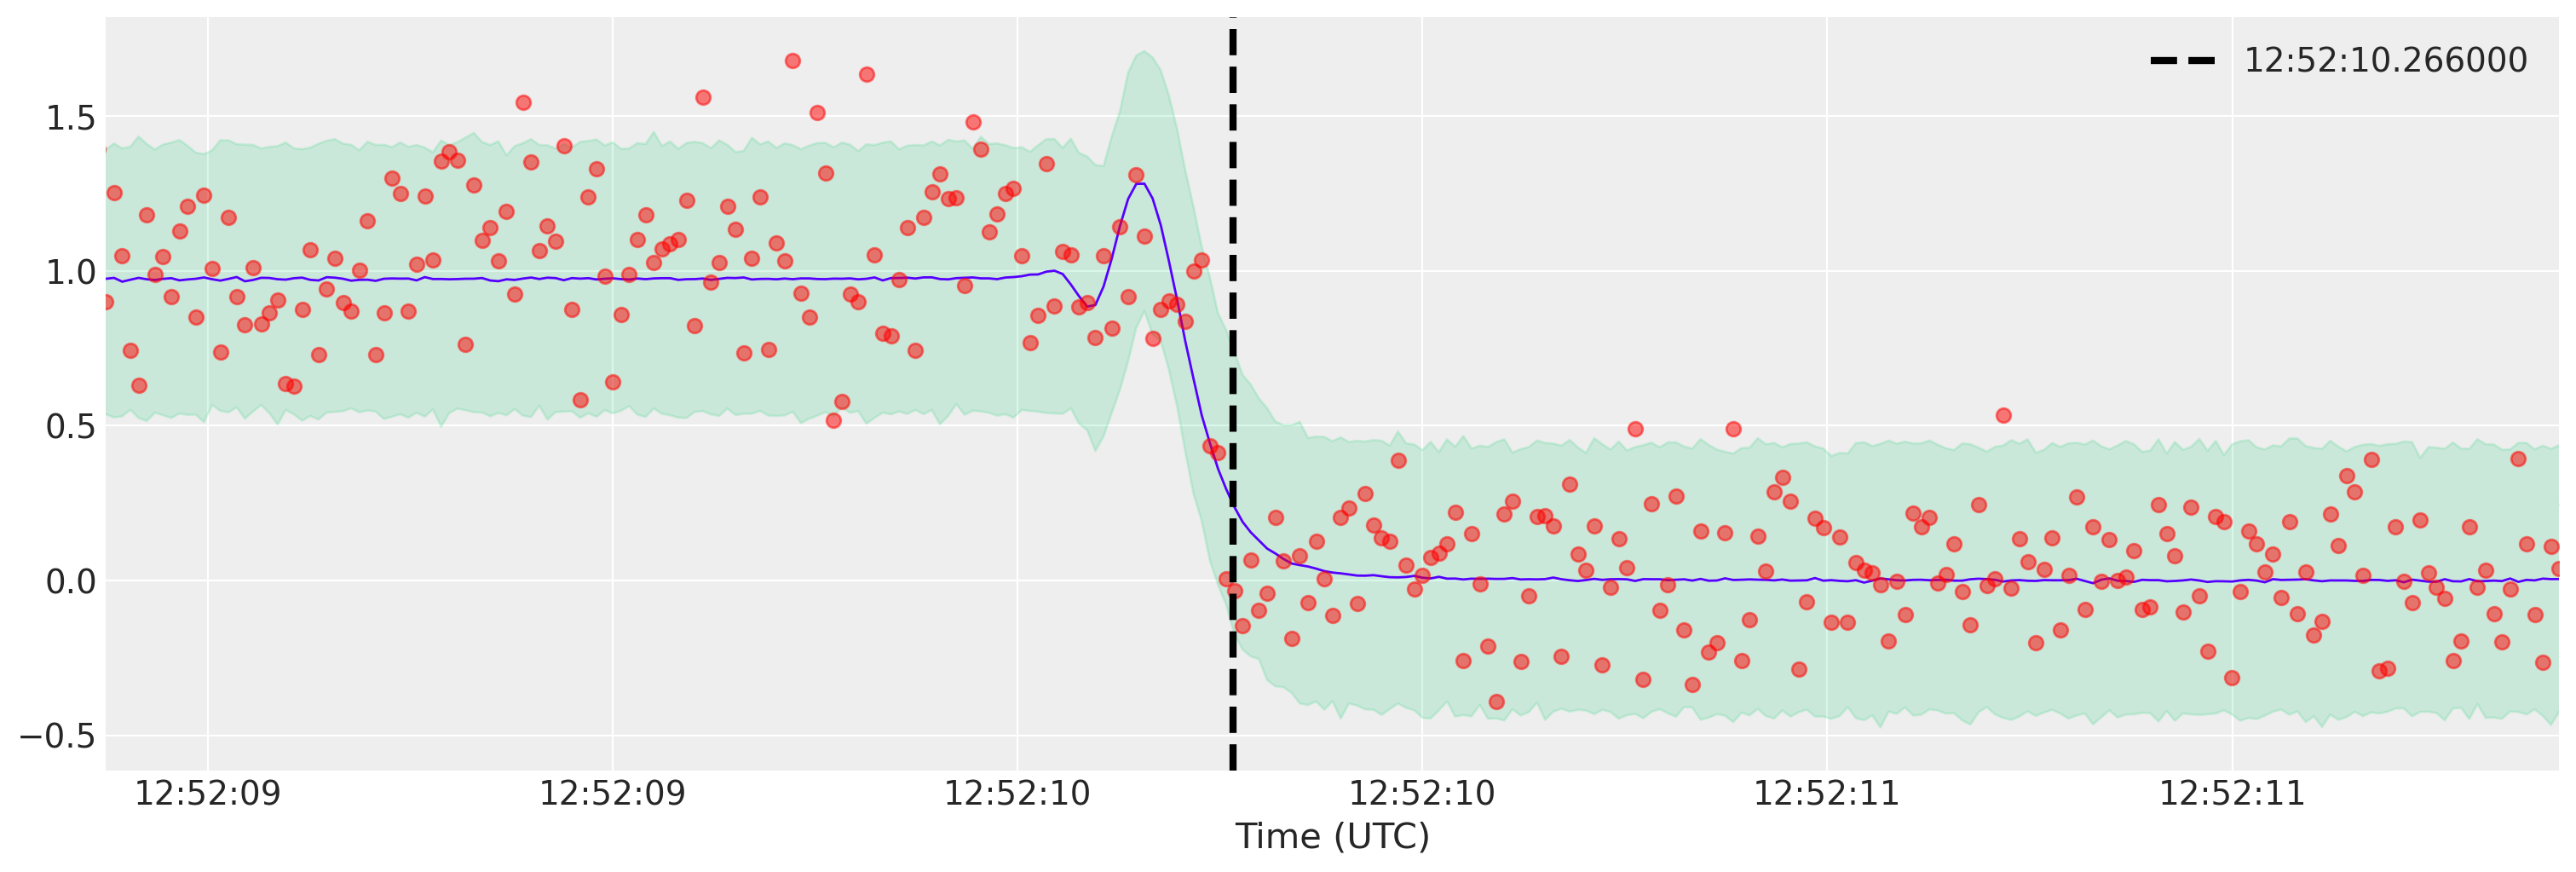

In [49]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(data_copy['Date'], mean_spp, linestyle='-', linewidth=1, color="#5500ff")
# ax.plot(data_copy['Time'], mean_spp, linestyle='-', linewidth=1, color="")
ax.fill_between(data_copy['Date'], crit_l, crit_u, alpha=0.15, color="#00cc66")
ax.plot(data_copy['Date'], value_scaled, 'ro', alpha=0.5)

plt.axvline(x = t_iso_time, color = 'k', lw=3, ls='--', label = t_iso_time.time())
plt.legend(loc = 'upper right')

#ax.plot(data['Frame'], data['Value'], 'ro', alpha=0.35)
# ax.set_xlabel('UTC (mm:ss.ssssss)')
ax.set_xlim(data_copy['Date'][300], data_copy['Date'][600]) # baris ke-# untuk kolom 'Time'
ax.set_xlabel('Time (UTC)')

date_form = mdates.DateFormatter("%H:%M:%S")#, tz=pytz.timezone(‘Australia/Sydney’))
#ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
#ax.xaxis.set_major_locator(mdates.HourLocator(byhour=None, interval=2))
ax.xaxis.set_major_formatter(date_form)
# ax.tick_params('x', labelrotation=45)

# data['Time'].dt.hour()

In [50]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

<AxesSubplot:xlabel='y_pred / y_pred'>

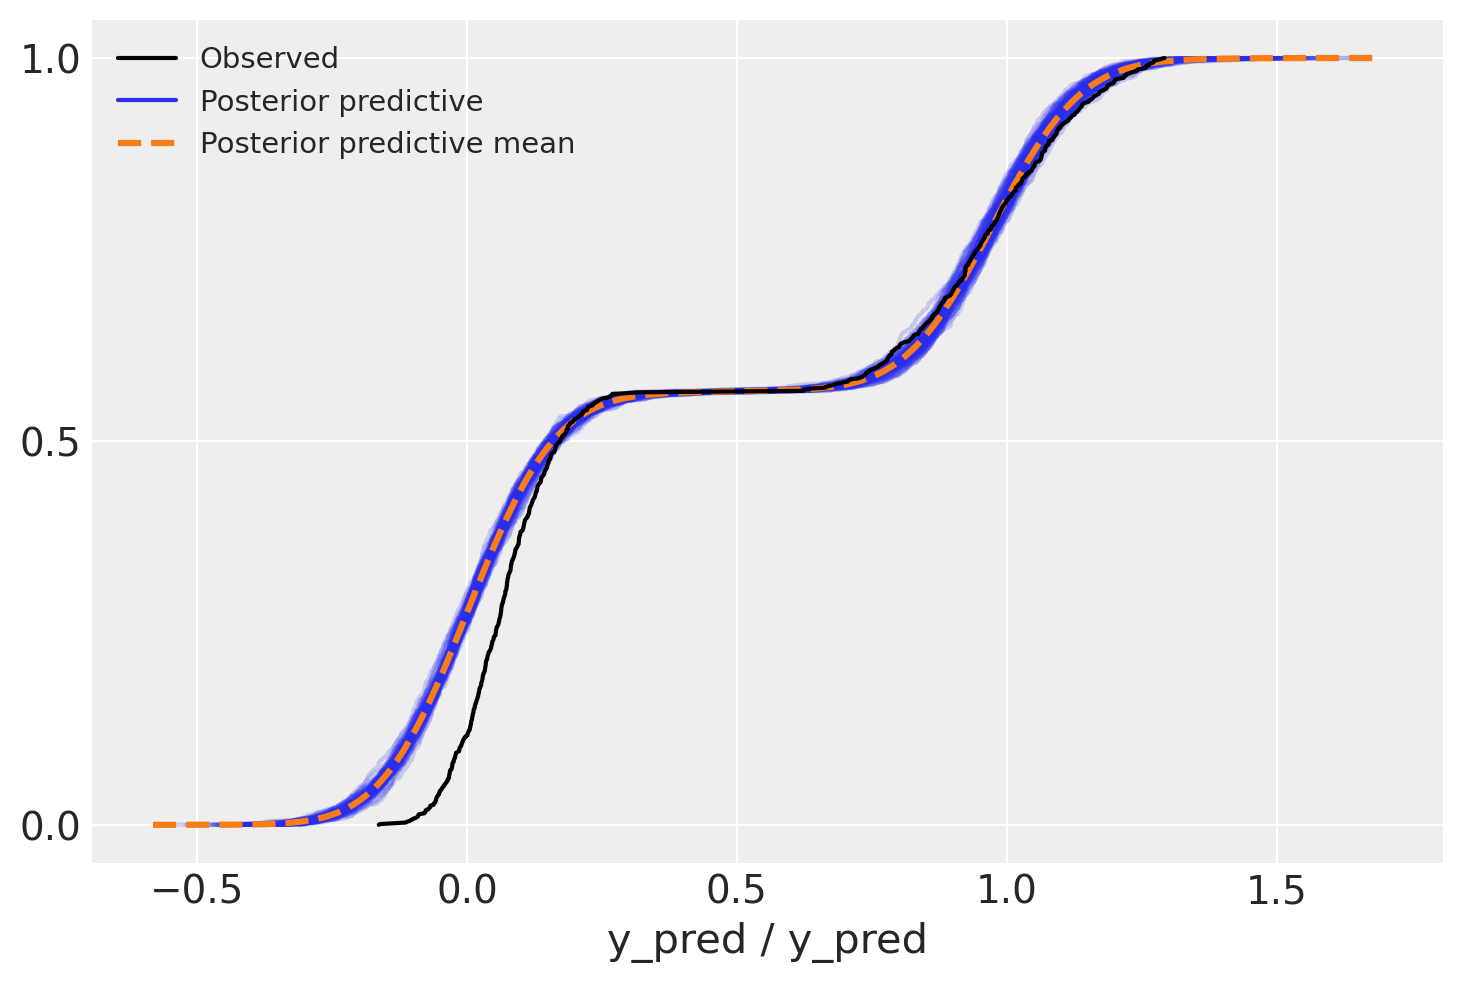

In [51]:
az.plot_ppc(idata, num_pp_samples=100, kind='cumulative')

<AxesSubplot:xlabel='y_pred / y_pred'>

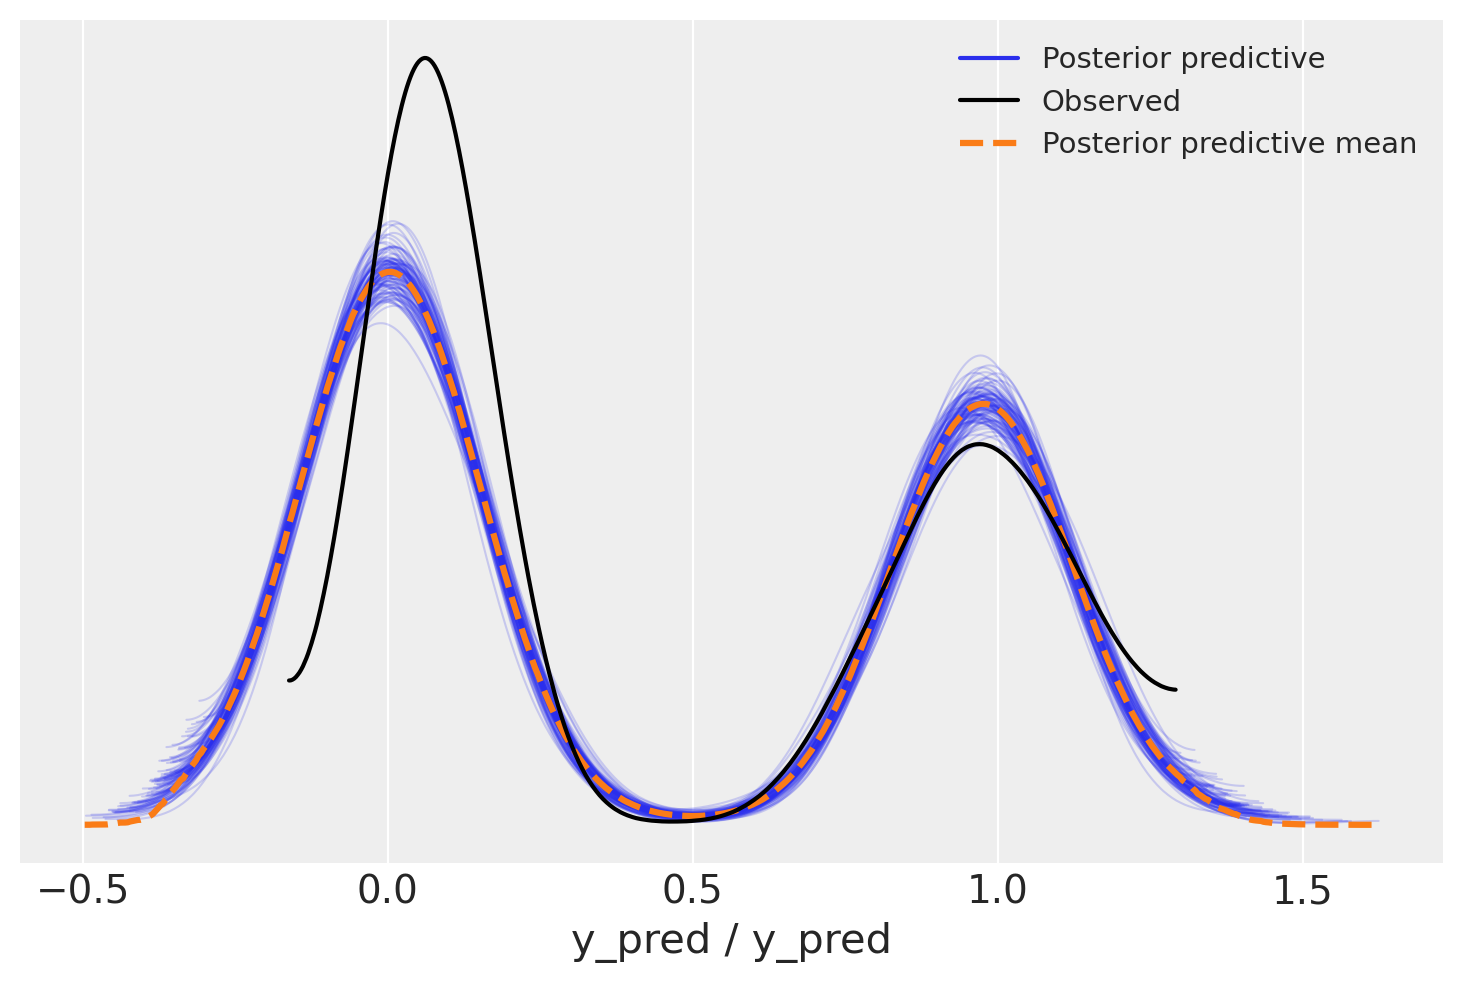

In [52]:
az.plot_ppc(idata, num_pp_samples=100)